# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

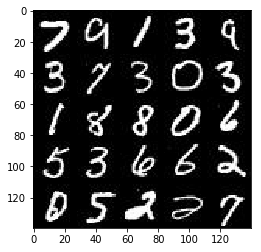

In [3]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

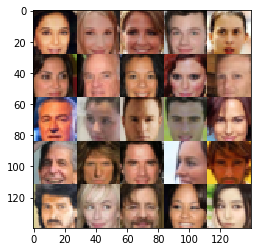

In [4]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse = not is_train):

        h1 = tf.layers.dense(z, 7*7*256)
        
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha*h1, h1)
        #7x7x256
        
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides = 2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha*h2, h2)
        #14x14x128
    
        logits = tf.layers.conv2d_transpose(h2, out_channel_dim, 5, strides = 2, padding='same')
        #28x28x3
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
   
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
   
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    input_real, input_z, learning_rate_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    #
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model 
                steps += 1
                
                batch_images = batch_images * 2
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                
                # Random noise
                z_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: z_noise})
                _ = sess.run(g_train_opt, feed_dict={input_z: z_noise, input_real: batch_images})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: z_noise, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_noise, input_real: batch_images})

                    print("Epoch {}/{}: ".format(epoch_i+1, epoch_count),
                      " - Discriminator Loss: {:.4f}:".format(train_loss_d),
                      " - Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("DONE");

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2:   - Discriminator Loss: 1.4290:  - Generator Loss: 0.3214
Epoch 1/2:   - Discriminator Loss: 1.2850:  - Generator Loss: 0.4342
Epoch 1/2:   - Discriminator Loss: 1.2446:  - Generator Loss: 0.4628
Epoch 1/2:   - Discriminator Loss: 1.2507:  - Generator Loss: 0.5591
Epoch 1/2:   - Discriminator Loss: 1.1627:  - Generator Loss: 0.6656
Epoch 1/2:   - Discriminator Loss: 1.2374:  - Generator Loss: 0.6604
Epoch 1/2:   - Discriminator Loss: 1.2215:  - Generator Loss: 0.6540
Epoch 1/2:   - Discriminator Loss: 1.0018:  - Generator Loss: 0.8498
Epoch 1/2:   - Discriminator Loss: 0.8944:  - Generator Loss: 0.8462
Epoch 1/2:   - Discriminator Loss: 0.8398:  - Generator Loss: 0.9459


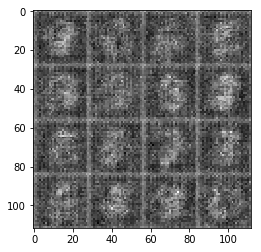

Epoch 1/2:   - Discriminator Loss: 0.7704:  - Generator Loss: 0.9921
Epoch 1/2:   - Discriminator Loss: 0.8278:  - Generator Loss: 1.0095
Epoch 1/2:   - Discriminator Loss: 0.9112:  - Generator Loss: 0.8854
Epoch 1/2:   - Discriminator Loss: 0.8319:  - Generator Loss: 0.9126
Epoch 1/2:   - Discriminator Loss: 0.8528:  - Generator Loss: 1.0636
Epoch 1/2:   - Discriminator Loss: 0.8566:  - Generator Loss: 0.9427
Epoch 1/2:   - Discriminator Loss: 0.8897:  - Generator Loss: 0.9831
Epoch 1/2:   - Discriminator Loss: 0.8903:  - Generator Loss: 0.9632
Epoch 1/2:   - Discriminator Loss: 1.0858:  - Generator Loss: 0.6973
Epoch 1/2:   - Discriminator Loss: 0.8677:  - Generator Loss: 0.9927


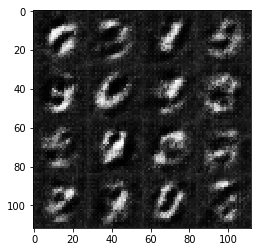

Epoch 1/2:   - Discriminator Loss: 0.9489:  - Generator Loss: 0.7985
Epoch 1/2:   - Discriminator Loss: 0.9473:  - Generator Loss: 0.7664
Epoch 1/2:   - Discriminator Loss: 0.9821:  - Generator Loss: 1.0140
Epoch 1/2:   - Discriminator Loss: 0.9723:  - Generator Loss: 0.9691
Epoch 1/2:   - Discriminator Loss: 1.1135:  - Generator Loss: 0.8496
Epoch 1/2:   - Discriminator Loss: 1.0609:  - Generator Loss: 0.9529
Epoch 1/2:   - Discriminator Loss: 1.0663:  - Generator Loss: 0.7167
Epoch 1/2:   - Discriminator Loss: 1.0711:  - Generator Loss: 0.6663
Epoch 1/2:   - Discriminator Loss: 1.0069:  - Generator Loss: 1.1299
Epoch 1/2:   - Discriminator Loss: 0.9378:  - Generator Loss: 1.0672


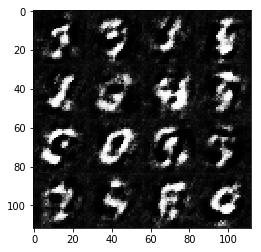

Epoch 1/2:   - Discriminator Loss: 1.0215:  - Generator Loss: 0.9594
Epoch 1/2:   - Discriminator Loss: 0.8828:  - Generator Loss: 1.1766
Epoch 1/2:   - Discriminator Loss: 1.0168:  - Generator Loss: 0.7417
Epoch 1/2:   - Discriminator Loss: 0.9689:  - Generator Loss: 1.0641
Epoch 1/2:   - Discriminator Loss: 1.0532:  - Generator Loss: 0.8711
Epoch 1/2:   - Discriminator Loss: 1.0138:  - Generator Loss: 0.9947
Epoch 1/2:   - Discriminator Loss: 1.0629:  - Generator Loss: 0.9137
Epoch 1/2:   - Discriminator Loss: 1.0348:  - Generator Loss: 0.9930
Epoch 1/2:   - Discriminator Loss: 1.0548:  - Generator Loss: 0.6209
Epoch 1/2:   - Discriminator Loss: 0.9932:  - Generator Loss: 0.8075


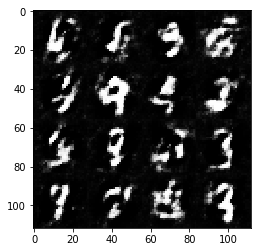

Epoch 1/2:   - Discriminator Loss: 1.0142:  - Generator Loss: 0.8736
Epoch 1/2:   - Discriminator Loss: 0.9909:  - Generator Loss: 0.9856
Epoch 1/2:   - Discriminator Loss: 1.0541:  - Generator Loss: 0.8878
Epoch 1/2:   - Discriminator Loss: 0.9290:  - Generator Loss: 0.9498
Epoch 1/2:   - Discriminator Loss: 1.0293:  - Generator Loss: 0.7839
Epoch 1/2:   - Discriminator Loss: 1.0488:  - Generator Loss: 0.8191
Epoch 1/2:   - Discriminator Loss: 1.1041:  - Generator Loss: 1.1080
Epoch 1/2:   - Discriminator Loss: 0.9801:  - Generator Loss: 0.9519
Epoch 1/2:   - Discriminator Loss: 1.0289:  - Generator Loss: 1.0788
Epoch 1/2:   - Discriminator Loss: 1.0293:  - Generator Loss: 0.8889


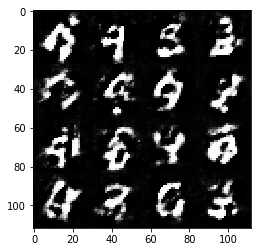

Epoch 1/2:   - Discriminator Loss: 0.9101:  - Generator Loss: 0.8965
Epoch 1/2:   - Discriminator Loss: 0.9310:  - Generator Loss: 1.1630
Epoch 1/2:   - Discriminator Loss: 0.8390:  - Generator Loss: 1.0535
Epoch 1/2:   - Discriminator Loss: 0.9445:  - Generator Loss: 0.9318
Epoch 1/2:   - Discriminator Loss: 0.9452:  - Generator Loss: 1.0370
Epoch 1/2:   - Discriminator Loss: 0.8847:  - Generator Loss: 0.8382
Epoch 1/2:   - Discriminator Loss: 0.7818:  - Generator Loss: 1.1126
Epoch 1/2:   - Discriminator Loss: 0.9007:  - Generator Loss: 1.0295
Epoch 1/2:   - Discriminator Loss: 0.9988:  - Generator Loss: 0.7820
Epoch 1/2:   - Discriminator Loss: 0.9005:  - Generator Loss: 0.8868


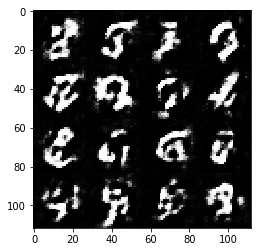

Epoch 1/2:   - Discriminator Loss: 0.8460:  - Generator Loss: 0.8980
Epoch 1/2:   - Discriminator Loss: 0.9312:  - Generator Loss: 1.0860
Epoch 1/2:   - Discriminator Loss: 0.9529:  - Generator Loss: 0.9795
Epoch 1/2:   - Discriminator Loss: 0.9287:  - Generator Loss: 0.9200
Epoch 1/2:   - Discriminator Loss: 0.9703:  - Generator Loss: 0.9434
Epoch 1/2:   - Discriminator Loss: 0.9367:  - Generator Loss: 1.0027
Epoch 1/2:   - Discriminator Loss: 0.8932:  - Generator Loss: 0.9499
Epoch 1/2:   - Discriminator Loss: 0.9575:  - Generator Loss: 0.8609
Epoch 1/2:   - Discriminator Loss: 0.9116:  - Generator Loss: 0.9098
Epoch 1/2:   - Discriminator Loss: 0.8210:  - Generator Loss: 1.0885


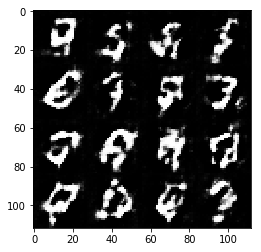

Epoch 1/2:   - Discriminator Loss: 0.9021:  - Generator Loss: 0.9655
Epoch 1/2:   - Discriminator Loss: 0.8724:  - Generator Loss: 1.0780
Epoch 1/2:   - Discriminator Loss: 0.8608:  - Generator Loss: 0.9674
Epoch 1/2:   - Discriminator Loss: 0.8718:  - Generator Loss: 0.8918
Epoch 1/2:   - Discriminator Loss: 0.9039:  - Generator Loss: 1.2828
Epoch 1/2:   - Discriminator Loss: 0.8993:  - Generator Loss: 0.8900
Epoch 1/2:   - Discriminator Loss: 0.9286:  - Generator Loss: 0.8805
Epoch 1/2:   - Discriminator Loss: 0.8558:  - Generator Loss: 1.1359
Epoch 1/2:   - Discriminator Loss: 0.8436:  - Generator Loss: 1.0236
Epoch 1/2:   - Discriminator Loss: 0.6774:  - Generator Loss: 1.3155


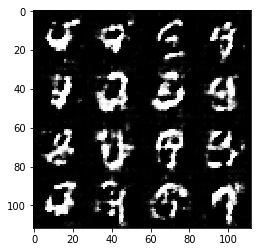

Epoch 1/2:   - Discriminator Loss: 0.7533:  - Generator Loss: 1.0566
Epoch 1/2:   - Discriminator Loss: 0.7492:  - Generator Loss: 1.3206
Epoch 1/2:   - Discriminator Loss: 0.7111:  - Generator Loss: 1.2161
Epoch 1/2:   - Discriminator Loss: 0.8086:  - Generator Loss: 0.9420
Epoch 1/2:   - Discriminator Loss: 0.7552:  - Generator Loss: 1.1924
Epoch 1/2:   - Discriminator Loss: 0.8023:  - Generator Loss: 1.0544
Epoch 1/2:   - Discriminator Loss: 0.8206:  - Generator Loss: 0.9389
Epoch 1/2:   - Discriminator Loss: 0.7654:  - Generator Loss: 1.1726
Epoch 1/2:   - Discriminator Loss: 0.7200:  - Generator Loss: 1.0604
Epoch 1/2:   - Discriminator Loss: 0.7566:  - Generator Loss: 1.0316


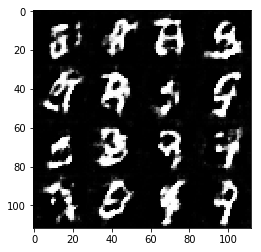

Epoch 1/2:   - Discriminator Loss: 0.7509:  - Generator Loss: 1.2305
Epoch 1/2:   - Discriminator Loss: 0.7137:  - Generator Loss: 1.4206
Epoch 1/2:   - Discriminator Loss: 0.6685:  - Generator Loss: 1.0972
Epoch 1/2:   - Discriminator Loss: 0.7650:  - Generator Loss: 1.0108
Epoch 1/2:   - Discriminator Loss: 0.7270:  - Generator Loss: 1.1359
Epoch 1/2:   - Discriminator Loss: 0.7905:  - Generator Loss: 0.8449
Epoch 1/2:   - Discriminator Loss: 0.7402:  - Generator Loss: 1.1730
Epoch 1/2:   - Discriminator Loss: 0.7271:  - Generator Loss: 1.1244
Epoch 1/2:   - Discriminator Loss: 0.7407:  - Generator Loss: 1.2800
Epoch 1/2:   - Discriminator Loss: 0.8180:  - Generator Loss: 1.1674


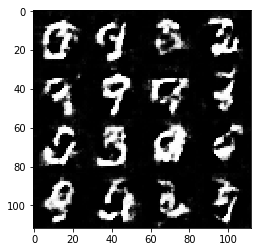

Epoch 1/2:   - Discriminator Loss: 0.9603:  - Generator Loss: 0.6970
Epoch 1/2:   - Discriminator Loss: 0.8117:  - Generator Loss: 0.9196
Epoch 1/2:   - Discriminator Loss: 0.6076:  - Generator Loss: 1.4067
Epoch 1/2:   - Discriminator Loss: 0.6773:  - Generator Loss: 1.6144
Epoch 1/2:   - Discriminator Loss: 0.7366:  - Generator Loss: 1.0863
Epoch 1/2:   - Discriminator Loss: 0.7397:  - Generator Loss: 1.0374
Epoch 1/2:   - Discriminator Loss: 0.6860:  - Generator Loss: 1.3804
Epoch 1/2:   - Discriminator Loss: 0.7263:  - Generator Loss: 1.4563
Epoch 1/2:   - Discriminator Loss: 0.6986:  - Generator Loss: 1.2397
Epoch 1/2:   - Discriminator Loss: 0.7740:  - Generator Loss: 1.1938


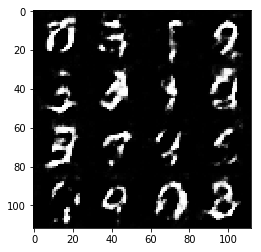

Epoch 1/2:   - Discriminator Loss: 0.6978:  - Generator Loss: 1.1689
Epoch 1/2:   - Discriminator Loss: 0.8527:  - Generator Loss: 1.1776
Epoch 1/2:   - Discriminator Loss: 0.6431:  - Generator Loss: 1.1656
Epoch 1/2:   - Discriminator Loss: 0.7695:  - Generator Loss: 0.9027
Epoch 1/2:   - Discriminator Loss: 0.7790:  - Generator Loss: 1.0309
Epoch 1/2:   - Discriminator Loss: 0.7973:  - Generator Loss: 0.8531
Epoch 1/2:   - Discriminator Loss: 0.6543:  - Generator Loss: 1.2539
Epoch 1/2:   - Discriminator Loss: 0.7221:  - Generator Loss: 1.1811
Epoch 1/2:   - Discriminator Loss: 0.6743:  - Generator Loss: 1.6305
Epoch 1/2:   - Discriminator Loss: 0.7537:  - Generator Loss: 1.5921


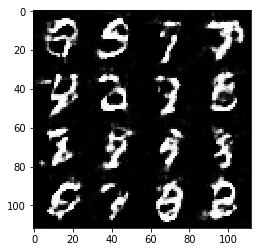

Epoch 1/2:   - Discriminator Loss: 0.5968:  - Generator Loss: 1.5550
Epoch 1/2:   - Discriminator Loss: 0.7581:  - Generator Loss: 1.2147
Epoch 1/2:   - Discriminator Loss: 0.6550:  - Generator Loss: 1.1214
Epoch 1/2:   - Discriminator Loss: 0.7046:  - Generator Loss: 1.0567
Epoch 1/2:   - Discriminator Loss: 0.9128:  - Generator Loss: 0.7355
Epoch 1/2:   - Discriminator Loss: 0.8422:  - Generator Loss: 0.9285
Epoch 1/2:   - Discriminator Loss: 0.9215:  - Generator Loss: 0.7769
Epoch 1/2:   - Discriminator Loss: 0.6735:  - Generator Loss: 1.3785
Epoch 1/2:   - Discriminator Loss: 0.7963:  - Generator Loss: 1.1822
Epoch 1/2:   - Discriminator Loss: 0.7721:  - Generator Loss: 1.2529


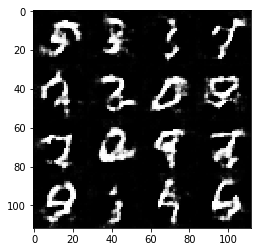

Epoch 1/2:   - Discriminator Loss: 0.8153:  - Generator Loss: 1.2566
Epoch 1/2:   - Discriminator Loss: 0.9411:  - Generator Loss: 0.6549
Epoch 1/2:   - Discriminator Loss: 0.7370:  - Generator Loss: 1.1274
Epoch 1/2:   - Discriminator Loss: 1.0850:  - Generator Loss: 1.7632
Epoch 1/2:   - Discriminator Loss: 0.8209:  - Generator Loss: 1.0386
Epoch 1/2:   - Discriminator Loss: 0.8759:  - Generator Loss: 0.8172
Epoch 1/2:   - Discriminator Loss: 0.7846:  - Generator Loss: 1.0133
Epoch 1/2:   - Discriminator Loss: 0.9322:  - Generator Loss: 1.1134
Epoch 1/2:   - Discriminator Loss: 0.7488:  - Generator Loss: 1.4640
Epoch 1/2:   - Discriminator Loss: 0.9433:  - Generator Loss: 0.7327


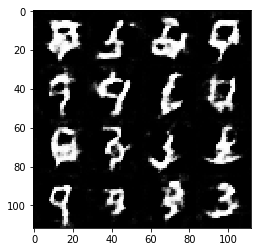

Epoch 1/2:   - Discriminator Loss: 0.9522:  - Generator Loss: 0.8200
Epoch 1/2:   - Discriminator Loss: 0.8560:  - Generator Loss: 1.1422
Epoch 1/2:   - Discriminator Loss: 0.9361:  - Generator Loss: 0.8919
Epoch 1/2:   - Discriminator Loss: 1.1260:  - Generator Loss: 0.5830
Epoch 1/2:   - Discriminator Loss: 0.8625:  - Generator Loss: 0.8596
Epoch 1/2:   - Discriminator Loss: 1.3357:  - Generator Loss: 0.4514
Epoch 1/2:   - Discriminator Loss: 0.9666:  - Generator Loss: 0.7974
Epoch 1/2:   - Discriminator Loss: 0.8947:  - Generator Loss: 1.0162
Epoch 1/2:   - Discriminator Loss: 1.0149:  - Generator Loss: 1.0147
Epoch 1/2:   - Discriminator Loss: 1.0185:  - Generator Loss: 0.8244


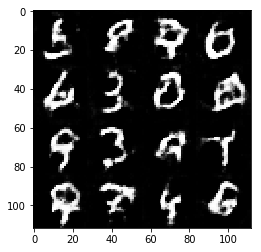

Epoch 1/2:   - Discriminator Loss: 1.0188:  - Generator Loss: 1.2322
Epoch 1/2:   - Discriminator Loss: 0.9147:  - Generator Loss: 0.7582
Epoch 1/2:   - Discriminator Loss: 0.9688:  - Generator Loss: 0.7842
Epoch 1/2:   - Discriminator Loss: 1.0346:  - Generator Loss: 0.9345
Epoch 1/2:   - Discriminator Loss: 0.9101:  - Generator Loss: 0.7125
Epoch 1/2:   - Discriminator Loss: 0.8266:  - Generator Loss: 1.0359
Epoch 1/2:   - Discriminator Loss: 0.8108:  - Generator Loss: 1.0127
Epoch 1/2:   - Discriminator Loss: 0.8803:  - Generator Loss: 0.9741
Epoch 1/2:   - Discriminator Loss: 0.9436:  - Generator Loss: 0.7773
Epoch 1/2:   - Discriminator Loss: 0.8219:  - Generator Loss: 0.9629


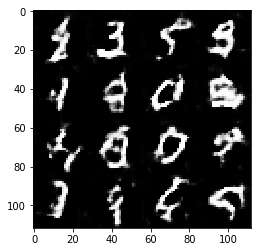

Epoch 1/2:   - Discriminator Loss: 0.9981:  - Generator Loss: 0.6180
Epoch 1/2:   - Discriminator Loss: 0.9447:  - Generator Loss: 0.8301
Epoch 1/2:   - Discriminator Loss: 0.7654:  - Generator Loss: 1.2316
Epoch 1/2:   - Discriminator Loss: 0.9901:  - Generator Loss: 0.7380
Epoch 1/2:   - Discriminator Loss: 0.7556:  - Generator Loss: 1.1425
Epoch 1/2:   - Discriminator Loss: 1.0396:  - Generator Loss: 0.6202
Epoch 1/2:   - Discriminator Loss: 0.7548:  - Generator Loss: 1.2260
Epoch 1/2:   - Discriminator Loss: 0.9187:  - Generator Loss: 0.8638
Epoch 1/2:   - Discriminator Loss: 0.9680:  - Generator Loss: 1.4278
Epoch 1/2:   - Discriminator Loss: 0.8831:  - Generator Loss: 1.0805


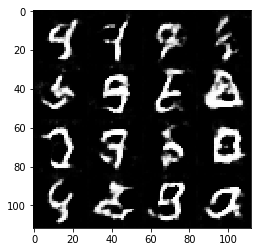

Epoch 1/2:   - Discriminator Loss: 0.8984:  - Generator Loss: 1.0089
Epoch 1/2:   - Discriminator Loss: 0.9526:  - Generator Loss: 0.7184
Epoch 1/2:   - Discriminator Loss: 0.8304:  - Generator Loss: 1.2780
Epoch 1/2:   - Discriminator Loss: 0.8564:  - Generator Loss: 0.8312
Epoch 1/2:   - Discriminator Loss: 0.8654:  - Generator Loss: 1.0404
Epoch 1/2:   - Discriminator Loss: 1.0051:  - Generator Loss: 0.6859
Epoch 1/2:   - Discriminator Loss: 0.7825:  - Generator Loss: 1.0108
Epoch 1/2:   - Discriminator Loss: 0.9038:  - Generator Loss: 0.9425
Epoch 1/2:   - Discriminator Loss: 0.8708:  - Generator Loss: 0.9378
Epoch 1/2:   - Discriminator Loss: 0.9067:  - Generator Loss: 0.7183


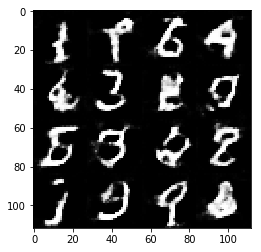

Epoch 1/2:   - Discriminator Loss: 0.8783:  - Generator Loss: 0.8782
Epoch 1/2:   - Discriminator Loss: 0.9360:  - Generator Loss: 0.8004
Epoch 1/2:   - Discriminator Loss: 0.9119:  - Generator Loss: 0.8623
Epoch 1/2:   - Discriminator Loss: 0.7555:  - Generator Loss: 1.1661
Epoch 1/2:   - Discriminator Loss: 0.7868:  - Generator Loss: 1.1439
Epoch 1/2:   - Discriminator Loss: 1.0299:  - Generator Loss: 0.7053
Epoch 1/2:   - Discriminator Loss: 0.8470:  - Generator Loss: 1.2267
Epoch 1/2:   - Discriminator Loss: 0.9335:  - Generator Loss: 1.1436
Epoch 1/2:   - Discriminator Loss: 1.0165:  - Generator Loss: 0.7835
Epoch 1/2:   - Discriminator Loss: 1.0717:  - Generator Loss: 0.6949


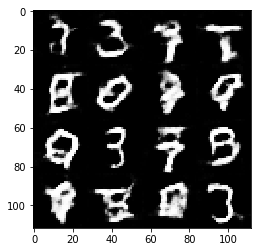

Epoch 1/2:   - Discriminator Loss: 0.9458:  - Generator Loss: 1.0760
Epoch 1/2:   - Discriminator Loss: 0.8458:  - Generator Loss: 0.9767
Epoch 1/2:   - Discriminator Loss: 1.0220:  - Generator Loss: 1.3851
Epoch 1/2:   - Discriminator Loss: 0.9369:  - Generator Loss: 0.9144
Epoch 1/2:   - Discriminator Loss: 0.6941:  - Generator Loss: 1.3854
Epoch 1/2:   - Discriminator Loss: 0.7959:  - Generator Loss: 0.9835
Epoch 1/2:   - Discriminator Loss: 0.9517:  - Generator Loss: 0.8110
Epoch 1/2:   - Discriminator Loss: 0.7509:  - Generator Loss: 1.1519
Epoch 1/2:   - Discriminator Loss: 0.9710:  - Generator Loss: 0.7136
Epoch 1/2:   - Discriminator Loss: 0.8528:  - Generator Loss: 1.0597


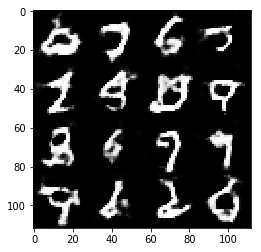

Epoch 2/2:   - Discriminator Loss: 0.8208:  - Generator Loss: 0.9142
Epoch 2/2:   - Discriminator Loss: 0.8914:  - Generator Loss: 1.0466
Epoch 2/2:   - Discriminator Loss: 0.8982:  - Generator Loss: 1.0919
Epoch 2/2:   - Discriminator Loss: 0.9271:  - Generator Loss: 1.0025
Epoch 2/2:   - Discriminator Loss: 0.8499:  - Generator Loss: 0.8959
Epoch 2/2:   - Discriminator Loss: 0.9604:  - Generator Loss: 0.7584
Epoch 2/2:   - Discriminator Loss: 0.7415:  - Generator Loss: 1.2829
Epoch 2/2:   - Discriminator Loss: 0.7870:  - Generator Loss: 1.0142
Epoch 2/2:   - Discriminator Loss: 0.7539:  - Generator Loss: 1.3774
Epoch 2/2:   - Discriminator Loss: 0.9677:  - Generator Loss: 0.7277


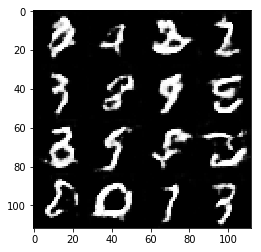

Epoch 2/2:   - Discriminator Loss: 0.9275:  - Generator Loss: 0.9175
Epoch 2/2:   - Discriminator Loss: 0.9230:  - Generator Loss: 0.8786
Epoch 2/2:   - Discriminator Loss: 0.8786:  - Generator Loss: 0.9049
Epoch 2/2:   - Discriminator Loss: 0.7349:  - Generator Loss: 1.3312
Epoch 2/2:   - Discriminator Loss: 1.0623:  - Generator Loss: 0.6959
Epoch 2/2:   - Discriminator Loss: 0.6741:  - Generator Loss: 1.2392
Epoch 2/2:   - Discriminator Loss: 1.0016:  - Generator Loss: 0.6846
Epoch 2/2:   - Discriminator Loss: 0.8699:  - Generator Loss: 0.8681
Epoch 2/2:   - Discriminator Loss: 0.9026:  - Generator Loss: 0.8122
Epoch 2/2:   - Discriminator Loss: 0.9822:  - Generator Loss: 0.6614


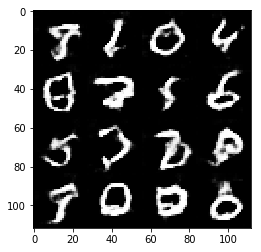

Epoch 2/2:   - Discriminator Loss: 1.0502:  - Generator Loss: 0.6679
Epoch 2/2:   - Discriminator Loss: 0.9374:  - Generator Loss: 0.8886
Epoch 2/2:   - Discriminator Loss: 1.0597:  - Generator Loss: 1.2933
Epoch 2/2:   - Discriminator Loss: 0.9470:  - Generator Loss: 0.8342
Epoch 2/2:   - Discriminator Loss: 0.9904:  - Generator Loss: 0.6814
Epoch 2/2:   - Discriminator Loss: 0.8765:  - Generator Loss: 0.9534
Epoch 2/2:   - Discriminator Loss: 0.7195:  - Generator Loss: 1.3132
Epoch 2/2:   - Discriminator Loss: 0.8164:  - Generator Loss: 0.9605
Epoch 2/2:   - Discriminator Loss: 1.0493:  - Generator Loss: 1.1046
Epoch 2/2:   - Discriminator Loss: 0.8244:  - Generator Loss: 1.3178


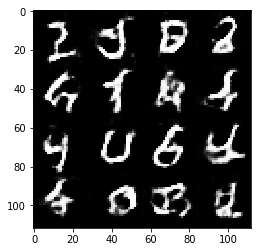

Epoch 2/2:   - Discriminator Loss: 0.9409:  - Generator Loss: 1.0690
Epoch 2/2:   - Discriminator Loss: 0.7582:  - Generator Loss: 1.1259
Epoch 2/2:   - Discriminator Loss: 0.8789:  - Generator Loss: 0.9657
Epoch 2/2:   - Discriminator Loss: 0.8452:  - Generator Loss: 1.0081
Epoch 2/2:   - Discriminator Loss: 1.0442:  - Generator Loss: 0.5980
Epoch 2/2:   - Discriminator Loss: 0.8226:  - Generator Loss: 0.9377
Epoch 2/2:   - Discriminator Loss: 0.8220:  - Generator Loss: 0.8953
Epoch 2/2:   - Discriminator Loss: 0.7030:  - Generator Loss: 1.1539
Epoch 2/2:   - Discriminator Loss: 0.8139:  - Generator Loss: 0.8397
Epoch 2/2:   - Discriminator Loss: 0.8203:  - Generator Loss: 0.9896


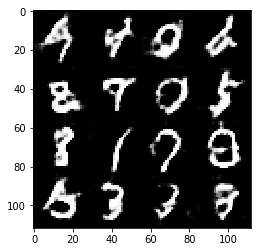

Epoch 2/2:   - Discriminator Loss: 0.9688:  - Generator Loss: 0.7479
Epoch 2/2:   - Discriminator Loss: 0.9509:  - Generator Loss: 1.3302
Epoch 2/2:   - Discriminator Loss: 0.9394:  - Generator Loss: 0.7936
Epoch 2/2:   - Discriminator Loss: 0.8703:  - Generator Loss: 0.8585
Epoch 2/2:   - Discriminator Loss: 0.8233:  - Generator Loss: 1.2610
Epoch 2/2:   - Discriminator Loss: 0.7979:  - Generator Loss: 0.8182
Epoch 2/2:   - Discriminator Loss: 0.7864:  - Generator Loss: 0.8567
Epoch 2/2:   - Discriminator Loss: 1.0624:  - Generator Loss: 0.5945
Epoch 2/2:   - Discriminator Loss: 0.7767:  - Generator Loss: 1.1840
Epoch 2/2:   - Discriminator Loss: 0.9438:  - Generator Loss: 0.8345


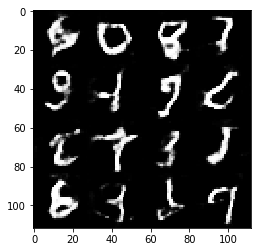

Epoch 2/2:   - Discriminator Loss: 0.9582:  - Generator Loss: 0.8033
Epoch 2/2:   - Discriminator Loss: 0.8058:  - Generator Loss: 0.8458
Epoch 2/2:   - Discriminator Loss: 0.7508:  - Generator Loss: 1.1351
Epoch 2/2:   - Discriminator Loss: 0.7412:  - Generator Loss: 1.0697
Epoch 2/2:   - Discriminator Loss: 0.7887:  - Generator Loss: 1.0681
Epoch 2/2:   - Discriminator Loss: 0.8093:  - Generator Loss: 1.0525
Epoch 2/2:   - Discriminator Loss: 0.9200:  - Generator Loss: 0.8598
Epoch 2/2:   - Discriminator Loss: 0.7706:  - Generator Loss: 0.9157
Epoch 2/2:   - Discriminator Loss: 0.9127:  - Generator Loss: 1.3016
Epoch 2/2:   - Discriminator Loss: 0.8437:  - Generator Loss: 0.8585


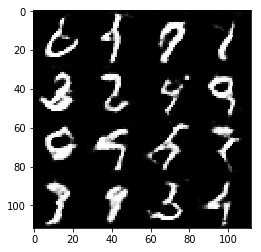

Epoch 2/2:   - Discriminator Loss: 0.8201:  - Generator Loss: 1.0441
Epoch 2/2:   - Discriminator Loss: 1.0262:  - Generator Loss: 1.5103
Epoch 2/2:   - Discriminator Loss: 0.7831:  - Generator Loss: 1.2390
Epoch 2/2:   - Discriminator Loss: 0.6835:  - Generator Loss: 1.3298
Epoch 2/2:   - Discriminator Loss: 1.0820:  - Generator Loss: 1.8657
Epoch 2/2:   - Discriminator Loss: 0.8759:  - Generator Loss: 0.9191
Epoch 2/2:   - Discriminator Loss: 0.7304:  - Generator Loss: 1.2111
Epoch 2/2:   - Discriminator Loss: 0.8852:  - Generator Loss: 1.1798
Epoch 2/2:   - Discriminator Loss: 1.2865:  - Generator Loss: 0.4603
Epoch 2/2:   - Discriminator Loss: 0.8362:  - Generator Loss: 0.9529


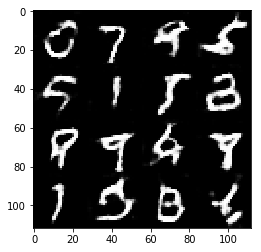

Epoch 2/2:   - Discriminator Loss: 0.8003:  - Generator Loss: 1.0995
Epoch 2/2:   - Discriminator Loss: 0.8223:  - Generator Loss: 1.3117
Epoch 2/2:   - Discriminator Loss: 0.8085:  - Generator Loss: 1.0184
Epoch 2/2:   - Discriminator Loss: 0.8674:  - Generator Loss: 0.9152
Epoch 2/2:   - Discriminator Loss: 0.7767:  - Generator Loss: 0.9535
Epoch 2/2:   - Discriminator Loss: 0.7192:  - Generator Loss: 0.9842
Epoch 2/2:   - Discriminator Loss: 0.9342:  - Generator Loss: 0.8149
Epoch 2/2:   - Discriminator Loss: 0.7905:  - Generator Loss: 1.0726
Epoch 2/2:   - Discriminator Loss: 0.8289:  - Generator Loss: 1.0762
Epoch 2/2:   - Discriminator Loss: 0.6936:  - Generator Loss: 1.3618


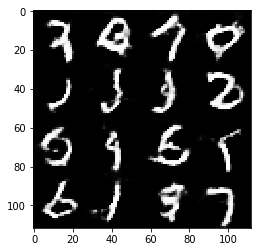

Epoch 2/2:   - Discriminator Loss: 0.8144:  - Generator Loss: 1.1088
Epoch 2/2:   - Discriminator Loss: 0.8053:  - Generator Loss: 1.0256
Epoch 2/2:   - Discriminator Loss: 0.8887:  - Generator Loss: 0.7973
Epoch 2/2:   - Discriminator Loss: 0.8617:  - Generator Loss: 1.3216
Epoch 2/2:   - Discriminator Loss: 0.8685:  - Generator Loss: 0.8669
Epoch 2/2:   - Discriminator Loss: 0.8908:  - Generator Loss: 0.8656
Epoch 2/2:   - Discriminator Loss: 0.7514:  - Generator Loss: 1.0219
Epoch 2/2:   - Discriminator Loss: 0.7989:  - Generator Loss: 1.0517
Epoch 2/2:   - Discriminator Loss: 0.8136:  - Generator Loss: 1.1603
Epoch 2/2:   - Discriminator Loss: 0.6254:  - Generator Loss: 1.2025


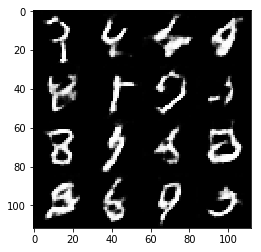

Epoch 2/2:   - Discriminator Loss: 0.8395:  - Generator Loss: 0.9438
Epoch 2/2:   - Discriminator Loss: 0.6901:  - Generator Loss: 1.1420
Epoch 2/2:   - Discriminator Loss: 0.6807:  - Generator Loss: 1.3228
Epoch 2/2:   - Discriminator Loss: 1.1998:  - Generator Loss: 0.5012
Epoch 2/2:   - Discriminator Loss: 0.6517:  - Generator Loss: 1.2069
Epoch 2/2:   - Discriminator Loss: 0.7753:  - Generator Loss: 0.9746
Epoch 2/2:   - Discriminator Loss: 0.7845:  - Generator Loss: 1.0977
Epoch 2/2:   - Discriminator Loss: 0.6861:  - Generator Loss: 1.0999
Epoch 2/2:   - Discriminator Loss: 0.8089:  - Generator Loss: 1.0240
Epoch 2/2:   - Discriminator Loss: 0.9490:  - Generator Loss: 0.7046


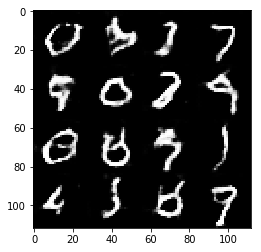

Epoch 2/2:   - Discriminator Loss: 0.8668:  - Generator Loss: 0.9545
Epoch 2/2:   - Discriminator Loss: 0.7799:  - Generator Loss: 1.2621
Epoch 2/2:   - Discriminator Loss: 0.7464:  - Generator Loss: 0.9675
Epoch 2/2:   - Discriminator Loss: 0.8249:  - Generator Loss: 0.9598
Epoch 2/2:   - Discriminator Loss: 0.9219:  - Generator Loss: 0.8041
Epoch 2/2:   - Discriminator Loss: 0.8378:  - Generator Loss: 1.0715
Epoch 2/2:   - Discriminator Loss: 0.7289:  - Generator Loss: 1.1730
Epoch 2/2:   - Discriminator Loss: 0.7391:  - Generator Loss: 1.1902
Epoch 2/2:   - Discriminator Loss: 0.7145:  - Generator Loss: 1.0905
Epoch 2/2:   - Discriminator Loss: 0.8214:  - Generator Loss: 0.9052


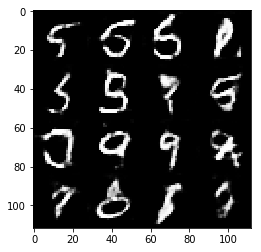

Epoch 2/2:   - Discriminator Loss: 0.8267:  - Generator Loss: 0.8760
Epoch 2/2:   - Discriminator Loss: 0.8106:  - Generator Loss: 1.1515
Epoch 2/2:   - Discriminator Loss: 0.9204:  - Generator Loss: 0.6518
Epoch 2/2:   - Discriminator Loss: 0.9065:  - Generator Loss: 0.7508
Epoch 2/2:   - Discriminator Loss: 0.6176:  - Generator Loss: 1.2489
Epoch 2/2:   - Discriminator Loss: 0.7957:  - Generator Loss: 0.9153
Epoch 2/2:   - Discriminator Loss: 0.7043:  - Generator Loss: 1.1697
Epoch 2/2:   - Discriminator Loss: 1.0226:  - Generator Loss: 0.6489
Epoch 2/2:   - Discriminator Loss: 0.8398:  - Generator Loss: 0.9864
Epoch 2/2:   - Discriminator Loss: 0.8667:  - Generator Loss: 1.8581


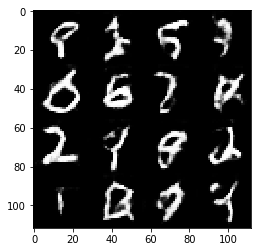

Epoch 2/2:   - Discriminator Loss: 0.7209:  - Generator Loss: 1.3961
Epoch 2/2:   - Discriminator Loss: 0.6969:  - Generator Loss: 1.2811
Epoch 2/2:   - Discriminator Loss: 0.6505:  - Generator Loss: 1.3213
Epoch 2/2:   - Discriminator Loss: 0.8125:  - Generator Loss: 0.9398
Epoch 2/2:   - Discriminator Loss: 0.7011:  - Generator Loss: 1.0653
Epoch 2/2:   - Discriminator Loss: 0.9658:  - Generator Loss: 0.6651
Epoch 2/2:   - Discriminator Loss: 0.7844:  - Generator Loss: 1.3082
Epoch 2/2:   - Discriminator Loss: 0.7943:  - Generator Loss: 0.9439
Epoch 2/2:   - Discriminator Loss: 0.6760:  - Generator Loss: 1.0269
Epoch 2/2:   - Discriminator Loss: 0.7463:  - Generator Loss: 1.3765


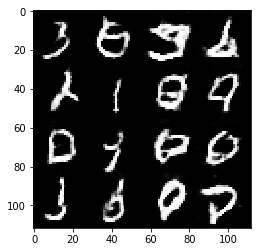

Epoch 2/2:   - Discriminator Loss: 1.0042:  - Generator Loss: 0.6112
Epoch 2/2:   - Discriminator Loss: 0.6776:  - Generator Loss: 1.0936
Epoch 2/2:   - Discriminator Loss: 0.7919:  - Generator Loss: 1.0187
Epoch 2/2:   - Discriminator Loss: 0.6853:  - Generator Loss: 1.3565
Epoch 2/2:   - Discriminator Loss: 0.6558:  - Generator Loss: 1.6573
Epoch 2/2:   - Discriminator Loss: 1.1168:  - Generator Loss: 0.4991
Epoch 2/2:   - Discriminator Loss: 0.7998:  - Generator Loss: 0.9900
Epoch 2/2:   - Discriminator Loss: 0.8396:  - Generator Loss: 0.8563
Epoch 2/2:   - Discriminator Loss: 0.9162:  - Generator Loss: 0.8222
Epoch 2/2:   - Discriminator Loss: 0.7464:  - Generator Loss: 1.0317


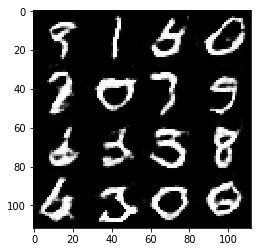

Epoch 2/2:   - Discriminator Loss: 1.1617:  - Generator Loss: 0.4625
Epoch 2/2:   - Discriminator Loss: 0.6263:  - Generator Loss: 1.1212
Epoch 2/2:   - Discriminator Loss: 0.7538:  - Generator Loss: 1.5793
Epoch 2/2:   - Discriminator Loss: 1.2008:  - Generator Loss: 0.5320
Epoch 2/2:   - Discriminator Loss: 0.7132:  - Generator Loss: 1.0086
Epoch 2/2:   - Discriminator Loss: 0.9733:  - Generator Loss: 0.7219
Epoch 2/2:   - Discriminator Loss: 0.6245:  - Generator Loss: 1.2412
Epoch 2/2:   - Discriminator Loss: 0.9258:  - Generator Loss: 0.6683
Epoch 2/2:   - Discriminator Loss: 0.7664:  - Generator Loss: 1.1692
Epoch 2/2:   - Discriminator Loss: 0.8627:  - Generator Loss: 0.7245


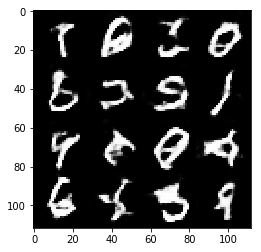

Epoch 2/2:   - Discriminator Loss: 0.7584:  - Generator Loss: 1.6770
Epoch 2/2:   - Discriminator Loss: 0.7404:  - Generator Loss: 0.9120
Epoch 2/2:   - Discriminator Loss: 0.8262:  - Generator Loss: 1.1190
Epoch 2/2:   - Discriminator Loss: 0.8517:  - Generator Loss: 0.8878
Epoch 2/2:   - Discriminator Loss: 0.7106:  - Generator Loss: 1.1833
Epoch 2/2:   - Discriminator Loss: 0.7027:  - Generator Loss: 1.1785
Epoch 2/2:   - Discriminator Loss: 0.6964:  - Generator Loss: 1.1170
Epoch 2/2:   - Discriminator Loss: 0.7592:  - Generator Loss: 0.9517
Epoch 2/2:   - Discriminator Loss: 0.7587:  - Generator Loss: 0.9757
Epoch 2/2:   - Discriminator Loss: 0.5870:  - Generator Loss: 1.5210


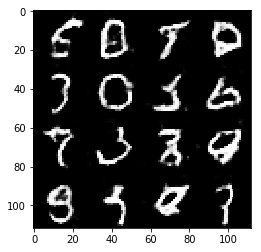

Epoch 2/2:   - Discriminator Loss: 0.7158:  - Generator Loss: 1.0791
Epoch 2/2:   - Discriminator Loss: 0.6868:  - Generator Loss: 0.9916
Epoch 2/2:   - Discriminator Loss: 0.6796:  - Generator Loss: 1.5802
Epoch 2/2:   - Discriminator Loss: 0.6843:  - Generator Loss: 1.2597
Epoch 2/2:   - Discriminator Loss: 0.8468:  - Generator Loss: 0.8874
Epoch 2/2:   - Discriminator Loss: 0.8711:  - Generator Loss: 0.7813
Epoch 2/2:   - Discriminator Loss: 0.8375:  - Generator Loss: 0.8599
Epoch 2/2:   - Discriminator Loss: 0.8953:  - Generator Loss: 1.0422
Epoch 2/2:   - Discriminator Loss: 0.5982:  - Generator Loss: 1.3048
Epoch 2/2:   - Discriminator Loss: 0.5549:  - Generator Loss: 2.0305


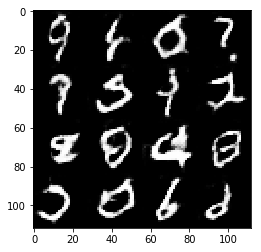

Epoch 2/2:   - Discriminator Loss: 0.7536:  - Generator Loss: 0.9216
Epoch 2/2:   - Discriminator Loss: 0.8210:  - Generator Loss: 0.7989
Epoch 2/2:   - Discriminator Loss: 0.6015:  - Generator Loss: 1.3605
Epoch 2/2:   - Discriminator Loss: 0.7916:  - Generator Loss: 0.7813
Epoch 2/2:   - Discriminator Loss: 0.6988:  - Generator Loss: 1.0188
Epoch 2/2:   - Discriminator Loss: 0.6586:  - Generator Loss: 1.1288
Epoch 2/2:   - Discriminator Loss: 0.6030:  - Generator Loss: 1.2387
Epoch 2/2:   - Discriminator Loss: 0.8619:  - Generator Loss: 1.2634
Epoch 2/2:   - Discriminator Loss: 0.6253:  - Generator Loss: 1.2530
Epoch 2/2:   - Discriminator Loss: 0.6465:  - Generator Loss: 1.0609


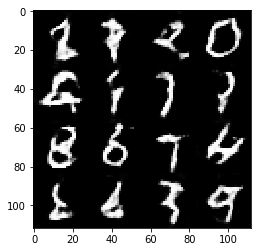

Epoch 2/2:   - Discriminator Loss: 0.6641:  - Generator Loss: 1.2835
Epoch 2/2:   - Discriminator Loss: 0.9090:  - Generator Loss: 0.6440
Epoch 2/2:   - Discriminator Loss: 0.6746:  - Generator Loss: 1.4423
Epoch 2/2:   - Discriminator Loss: 0.6259:  - Generator Loss: 1.1759
Epoch 2/2:   - Discriminator Loss: 0.5497:  - Generator Loss: 1.3430
Epoch 2/2:   - Discriminator Loss: 0.7679:  - Generator Loss: 0.9207
Epoch 2/2:   - Discriminator Loss: 0.6292:  - Generator Loss: 1.0872
Epoch 2/2:   - Discriminator Loss: 0.6294:  - Generator Loss: 1.1784
Epoch 2/2:   - Discriminator Loss: 0.6756:  - Generator Loss: 1.0451
Epoch 2/2:   - Discriminator Loss: 0.8276:  - Generator Loss: 0.8304


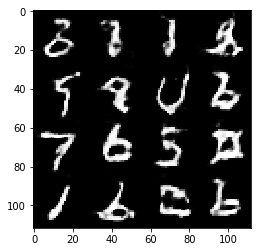

Epoch 2/2:   - Discriminator Loss: 0.6748:  - Generator Loss: 1.2041
Epoch 2/2:   - Discriminator Loss: 0.5899:  - Generator Loss: 1.4160
Epoch 2/2:   - Discriminator Loss: 0.6844:  - Generator Loss: 1.3500
Epoch 2/2:   - Discriminator Loss: 0.6854:  - Generator Loss: 1.0751
Epoch 2/2:   - Discriminator Loss: 0.6075:  - Generator Loss: 1.1535
Epoch 2/2:   - Discriminator Loss: 0.5080:  - Generator Loss: 1.5322
Epoch 2/2:   - Discriminator Loss: 0.7357:  - Generator Loss: 0.9981
Epoch 2/2:   - Discriminator Loss: 0.5514:  - Generator Loss: 1.3391
Epoch 2/2:   - Discriminator Loss: 0.6042:  - Generator Loss: 1.1556
Epoch 2/2:   - Discriminator Loss: 0.6231:  - Generator Loss: 1.8098


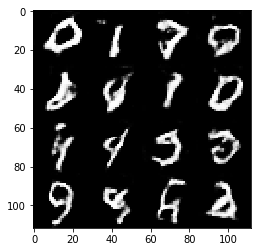

DONE


In [ ]:
batch_size = 30
z_dim = 150
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1:   - Discriminator Loss: 1.9535:  - Generator Loss: 0.2141
Epoch 1/1:   - Discriminator Loss: 1.8901:  - Generator Loss: 0.2734
Epoch 1/1:   - Discriminator Loss: 1.5222:  - Generator Loss: 0.4200
Epoch 1/1:   - Discriminator Loss: 1.2725:  - Generator Loss: 0.4853
Epoch 1/1:   - Discriminator Loss: 1.1276:  - Generator Loss: 0.5922
Epoch 1/1:   - Discriminator Loss: 0.9886:  - Generator Loss: 0.6985
Epoch 1/1:   - Discriminator Loss: 0.8415:  - Generator Loss: 0.7899
Epoch 1/1:   - Discriminator Loss: 0.9721:  - Generator Loss: 0.8330
Epoch 1/1:   - Discriminator Loss: 1.0033:  - Generator Loss: 0.9295
Epoch 1/1:   - Discriminator Loss: 0.5931:  - Generator Loss: 1.3830


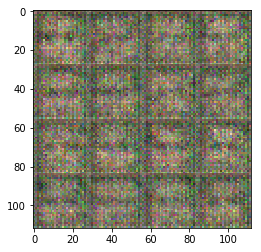

Epoch 1/1:   - Discriminator Loss: 0.7099:  - Generator Loss: 1.0716
Epoch 1/1:   - Discriminator Loss: 0.8339:  - Generator Loss: 1.0572
Epoch 1/1:   - Discriminator Loss: 1.0009:  - Generator Loss: 1.1123
Epoch 1/1:   - Discriminator Loss: 0.9221:  - Generator Loss: 1.2446
Epoch 1/1:   - Discriminator Loss: 0.7263:  - Generator Loss: 1.2042
Epoch 1/1:   - Discriminator Loss: 0.9402:  - Generator Loss: 0.8881
Epoch 1/1:   - Discriminator Loss: 1.0580:  - Generator Loss: 0.7691
Epoch 1/1:   - Discriminator Loss: 0.8243:  - Generator Loss: 1.1694
Epoch 1/1:   - Discriminator Loss: 0.9485:  - Generator Loss: 1.0756
Epoch 1/1:   - Discriminator Loss: 0.9175:  - Generator Loss: 0.9040


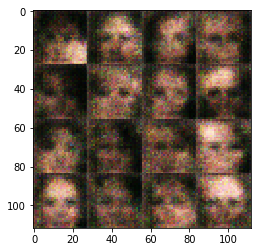

Epoch 1/1:   - Discriminator Loss: 0.8691:  - Generator Loss: 1.0474
Epoch 1/1:   - Discriminator Loss: 0.9366:  - Generator Loss: 1.0877
Epoch 1/1:   - Discriminator Loss: 1.0517:  - Generator Loss: 0.8304
Epoch 1/1:   - Discriminator Loss: 0.9229:  - Generator Loss: 0.9247
Epoch 1/1:   - Discriminator Loss: 0.9090:  - Generator Loss: 1.0392
Epoch 1/1:   - Discriminator Loss: 0.7782:  - Generator Loss: 1.1387
Epoch 1/1:   - Discriminator Loss: 0.9988:  - Generator Loss: 0.9981
Epoch 1/1:   - Discriminator Loss: 0.8456:  - Generator Loss: 1.0884
Epoch 1/1:   - Discriminator Loss: 0.9604:  - Generator Loss: 0.8983
Epoch 1/1:   - Discriminator Loss: 1.0596:  - Generator Loss: 0.9131


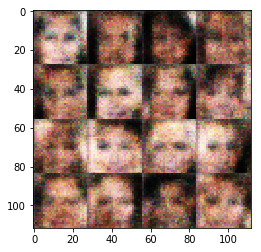

Epoch 1/1:   - Discriminator Loss: 1.0804:  - Generator Loss: 0.8487
Epoch 1/1:   - Discriminator Loss: 0.9634:  - Generator Loss: 0.9740
Epoch 1/1:   - Discriminator Loss: 0.9973:  - Generator Loss: 0.9527
Epoch 1/1:   - Discriminator Loss: 1.1502:  - Generator Loss: 0.9188
Epoch 1/1:   - Discriminator Loss: 1.4160:  - Generator Loss: 0.6516
Epoch 1/1:   - Discriminator Loss: 1.4593:  - Generator Loss: 0.5238
Epoch 1/1:   - Discriminator Loss: 1.3274:  - Generator Loss: 0.6597
Epoch 1/1:   - Discriminator Loss: 1.0213:  - Generator Loss: 0.8461
Epoch 1/1:   - Discriminator Loss: 1.1516:  - Generator Loss: 0.7812
Epoch 1/1:   - Discriminator Loss: 1.2892:  - Generator Loss: 0.8278


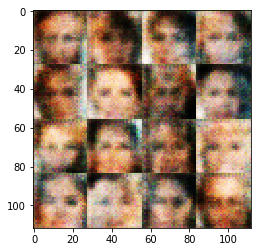

Epoch 1/1:   - Discriminator Loss: 1.3138:  - Generator Loss: 0.6466
Epoch 1/1:   - Discriminator Loss: 1.1095:  - Generator Loss: 0.8525
Epoch 1/1:   - Discriminator Loss: 1.1863:  - Generator Loss: 0.8336
Epoch 1/1:   - Discriminator Loss: 1.2378:  - Generator Loss: 0.6845
Epoch 1/1:   - Discriminator Loss: 1.2211:  - Generator Loss: 0.8177
Epoch 1/1:   - Discriminator Loss: 1.3991:  - Generator Loss: 1.0874
Epoch 1/1:   - Discriminator Loss: 1.2424:  - Generator Loss: 0.8139
Epoch 1/1:   - Discriminator Loss: 1.3564:  - Generator Loss: 0.6091
Epoch 1/1:   - Discriminator Loss: 1.2303:  - Generator Loss: 0.8244
Epoch 1/1:   - Discriminator Loss: 1.2945:  - Generator Loss: 0.6981


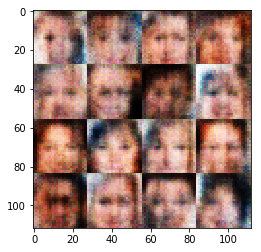

Epoch 1/1:   - Discriminator Loss: 1.1760:  - Generator Loss: 0.7979
Epoch 1/1:   - Discriminator Loss: 1.0929:  - Generator Loss: 0.9795
Epoch 1/1:   - Discriminator Loss: 1.0915:  - Generator Loss: 1.0078
Epoch 1/1:   - Discriminator Loss: 1.2870:  - Generator Loss: 0.6634
Epoch 1/1:   - Discriminator Loss: 1.2886:  - Generator Loss: 0.6038
Epoch 1/1:   - Discriminator Loss: 1.3096:  - Generator Loss: 0.6572
Epoch 1/1:   - Discriminator Loss: 1.4107:  - Generator Loss: 0.7292
Epoch 1/1:   - Discriminator Loss: 1.1581:  - Generator Loss: 0.8200
Epoch 1/1:   - Discriminator Loss: 1.3211:  - Generator Loss: 0.5979
Epoch 1/1:   - Discriminator Loss: 1.1344:  - Generator Loss: 0.7801


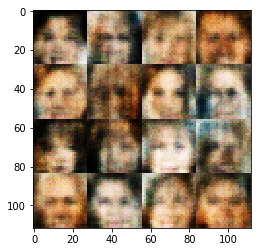

Epoch 1/1:   - Discriminator Loss: 1.2964:  - Generator Loss: 0.7594
Epoch 1/1:   - Discriminator Loss: 1.1228:  - Generator Loss: 1.0224
Epoch 1/1:   - Discriminator Loss: 1.3553:  - Generator Loss: 0.6123
Epoch 1/1:   - Discriminator Loss: 1.1294:  - Generator Loss: 0.8226
Epoch 1/1:   - Discriminator Loss: 0.9467:  - Generator Loss: 1.0357
Epoch 1/1:   - Discriminator Loss: 1.2151:  - Generator Loss: 0.8398
Epoch 1/1:   - Discriminator Loss: 1.1662:  - Generator Loss: 0.8540
Epoch 1/1:   - Discriminator Loss: 1.0561:  - Generator Loss: 0.9139
Epoch 1/1:   - Discriminator Loss: 1.2335:  - Generator Loss: 0.7713
Epoch 1/1:   - Discriminator Loss: 1.1844:  - Generator Loss: 0.8398


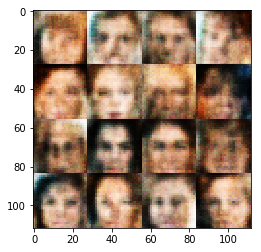

Epoch 1/1:   - Discriminator Loss: 1.3115:  - Generator Loss: 0.6342
Epoch 1/1:   - Discriminator Loss: 1.2182:  - Generator Loss: 0.9783
Epoch 1/1:   - Discriminator Loss: 1.1417:  - Generator Loss: 1.0111
Epoch 1/1:   - Discriminator Loss: 0.9947:  - Generator Loss: 0.9847
Epoch 1/1:   - Discriminator Loss: 1.0335:  - Generator Loss: 0.9182
Epoch 1/1:   - Discriminator Loss: 1.2327:  - Generator Loss: 0.9103
Epoch 1/1:   - Discriminator Loss: 1.1506:  - Generator Loss: 0.7933
Epoch 1/1:   - Discriminator Loss: 1.1176:  - Generator Loss: 0.7741
Epoch 1/1:   - Discriminator Loss: 1.1381:  - Generator Loss: 0.9065
Epoch 1/1:   - Discriminator Loss: 1.2135:  - Generator Loss: 0.8404


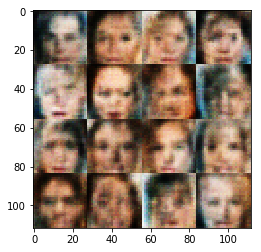

Epoch 1/1:   - Discriminator Loss: 1.2066:  - Generator Loss: 0.9732
Epoch 1/1:   - Discriminator Loss: 1.3771:  - Generator Loss: 0.6441
Epoch 1/1:   - Discriminator Loss: 1.0520:  - Generator Loss: 1.0100
Epoch 1/1:   - Discriminator Loss: 1.1722:  - Generator Loss: 0.7752
Epoch 1/1:   - Discriminator Loss: 1.3569:  - Generator Loss: 0.6402
Epoch 1/1:   - Discriminator Loss: 1.0425:  - Generator Loss: 0.8188
Epoch 1/1:   - Discriminator Loss: 0.9267:  - Generator Loss: 0.9921
Epoch 1/1:   - Discriminator Loss: 1.0683:  - Generator Loss: 0.8919
Epoch 1/1:   - Discriminator Loss: 1.0868:  - Generator Loss: 0.8332
Epoch 1/1:   - Discriminator Loss: 1.0681:  - Generator Loss: 0.9333


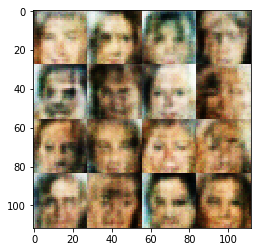

Epoch 1/1:   - Discriminator Loss: 1.0717:  - Generator Loss: 0.7914
Epoch 1/1:   - Discriminator Loss: 1.0113:  - Generator Loss: 0.8580
Epoch 1/1:   - Discriminator Loss: 1.1229:  - Generator Loss: 0.6790
Epoch 1/1:   - Discriminator Loss: 1.1197:  - Generator Loss: 0.9370
Epoch 1/1:   - Discriminator Loss: 1.1246:  - Generator Loss: 0.7299
Epoch 1/1:   - Discriminator Loss: 1.0240:  - Generator Loss: 0.9900
Epoch 1/1:   - Discriminator Loss: 1.1445:  - Generator Loss: 0.9254
Epoch 1/1:   - Discriminator Loss: 1.0774:  - Generator Loss: 0.8979
Epoch 1/1:   - Discriminator Loss: 1.0512:  - Generator Loss: 0.8635
Epoch 1/1:   - Discriminator Loss: 1.0936:  - Generator Loss: 0.8481


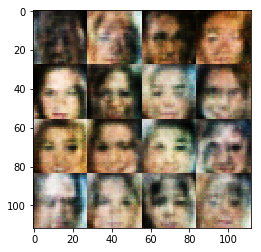

Epoch 1/1:   - Discriminator Loss: 1.3251:  - Generator Loss: 0.6823
Epoch 1/1:   - Discriminator Loss: 1.2421:  - Generator Loss: 0.6938
Epoch 1/1:   - Discriminator Loss: 1.0665:  - Generator Loss: 0.7351
Epoch 1/1:   - Discriminator Loss: 1.2045:  - Generator Loss: 0.8188
Epoch 1/1:   - Discriminator Loss: 1.1835:  - Generator Loss: 0.7636
Epoch 1/1:   - Discriminator Loss: 1.0989:  - Generator Loss: 0.8837
Epoch 1/1:   - Discriminator Loss: 1.1832:  - Generator Loss: 0.6579
Epoch 1/1:   - Discriminator Loss: 1.1346:  - Generator Loss: 0.7084
Epoch 1/1:   - Discriminator Loss: 0.9543:  - Generator Loss: 0.9834
Epoch 1/1:   - Discriminator Loss: 1.0893:  - Generator Loss: 0.7382


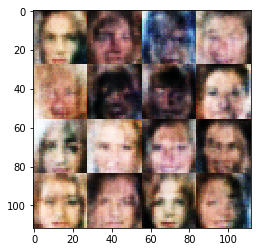

Epoch 1/1:   - Discriminator Loss: 1.0009:  - Generator Loss: 0.9551
Epoch 1/1:   - Discriminator Loss: 0.9001:  - Generator Loss: 1.0537
Epoch 1/1:   - Discriminator Loss: 1.2474:  - Generator Loss: 0.7906
Epoch 1/1:   - Discriminator Loss: 0.9300:  - Generator Loss: 1.1329
Epoch 1/1:   - Discriminator Loss: 0.8839:  - Generator Loss: 1.2426
Epoch 1/1:   - Discriminator Loss: 0.9254:  - Generator Loss: 0.9111
Epoch 1/1:   - Discriminator Loss: 0.9359:  - Generator Loss: 0.9471
Epoch 1/1:   - Discriminator Loss: 0.9353:  - Generator Loss: 1.0820
Epoch 1/1:   - Discriminator Loss: 1.1981:  - Generator Loss: 0.8335
Epoch 1/1:   - Discriminator Loss: 1.0407:  - Generator Loss: 0.9815


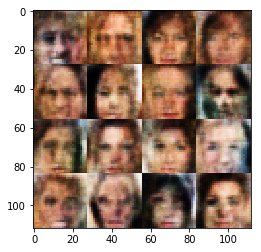

Epoch 1/1:   - Discriminator Loss: 1.2378:  - Generator Loss: 0.6760
Epoch 1/1:   - Discriminator Loss: 1.0735:  - Generator Loss: 0.8243
Epoch 1/1:   - Discriminator Loss: 1.0060:  - Generator Loss: 0.8323
Epoch 1/1:   - Discriminator Loss: 1.1095:  - Generator Loss: 0.8432
Epoch 1/1:   - Discriminator Loss: 0.9210:  - Generator Loss: 0.8418
Epoch 1/1:   - Discriminator Loss: 1.1947:  - Generator Loss: 0.7716
Epoch 1/1:   - Discriminator Loss: 1.0173:  - Generator Loss: 0.7800
Epoch 1/1:   - Discriminator Loss: 1.2654:  - Generator Loss: 0.5957
Epoch 1/1:   - Discriminator Loss: 0.9106:  - Generator Loss: 1.1089
Epoch 1/1:   - Discriminator Loss: 1.2102:  - Generator Loss: 0.7098


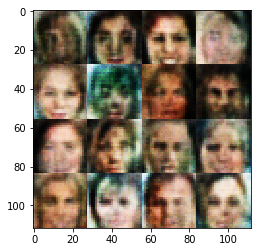

Epoch 1/1:   - Discriminator Loss: 0.8734:  - Generator Loss: 0.9800
Epoch 1/1:   - Discriminator Loss: 1.2400:  - Generator Loss: 0.6576
Epoch 1/1:   - Discriminator Loss: 1.3629:  - Generator Loss: 0.6262
Epoch 1/1:   - Discriminator Loss: 1.4980:  - Generator Loss: 0.4216
Epoch 1/1:   - Discriminator Loss: 1.3965:  - Generator Loss: 0.6767
Epoch 1/1:   - Discriminator Loss: 1.2032:  - Generator Loss: 0.6954
Epoch 1/1:   - Discriminator Loss: 1.2378:  - Generator Loss: 0.9304
Epoch 1/1:   - Discriminator Loss: 0.9823:  - Generator Loss: 0.9147
Epoch 1/1:   - Discriminator Loss: 1.3082:  - Generator Loss: 0.6114
Epoch 1/1:   - Discriminator Loss: 1.0266:  - Generator Loss: 0.7607


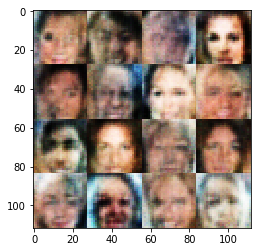

Epoch 1/1:   - Discriminator Loss: 0.9663:  - Generator Loss: 0.8733
Epoch 1/1:   - Discriminator Loss: 1.0536:  - Generator Loss: 0.8661
Epoch 1/1:   - Discriminator Loss: 1.4963:  - Generator Loss: 0.5201
Epoch 1/1:   - Discriminator Loss: 1.3396:  - Generator Loss: 0.5375
Epoch 1/1:   - Discriminator Loss: 1.2945:  - Generator Loss: 0.7138
Epoch 1/1:   - Discriminator Loss: 1.2817:  - Generator Loss: 0.7048
Epoch 1/1:   - Discriminator Loss: 1.0117:  - Generator Loss: 1.0242
Epoch 1/1:   - Discriminator Loss: 1.3031:  - Generator Loss: 0.6577
Epoch 1/1:   - Discriminator Loss: 1.3201:  - Generator Loss: 0.6879
Epoch 1/1:   - Discriminator Loss: 1.2188:  - Generator Loss: 0.7436


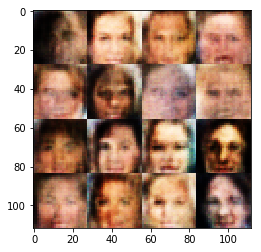

Epoch 1/1:   - Discriminator Loss: 1.4058:  - Generator Loss: 0.6139
Epoch 1/1:   - Discriminator Loss: 1.2732:  - Generator Loss: 0.8078
Epoch 1/1:   - Discriminator Loss: 1.5425:  - Generator Loss: 0.5718
Epoch 1/1:   - Discriminator Loss: 1.3684:  - Generator Loss: 0.5561
Epoch 1/1:   - Discriminator Loss: 1.2557:  - Generator Loss: 0.7035
Epoch 1/1:   - Discriminator Loss: 1.0613:  - Generator Loss: 0.8277
Epoch 1/1:   - Discriminator Loss: 1.3370:  - Generator Loss: 0.7896
Epoch 1/1:   - Discriminator Loss: 1.4452:  - Generator Loss: 0.5397
Epoch 1/1:   - Discriminator Loss: 1.5024:  - Generator Loss: 0.7267
Epoch 1/1:   - Discriminator Loss: 1.3673:  - Generator Loss: 0.6600


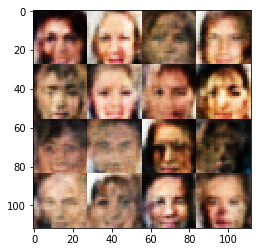

Epoch 1/1:   - Discriminator Loss: 1.4395:  - Generator Loss: 0.4938
Epoch 1/1:   - Discriminator Loss: 1.3731:  - Generator Loss: 0.6097
Epoch 1/1:   - Discriminator Loss: 1.3786:  - Generator Loss: 0.5750
Epoch 1/1:   - Discriminator Loss: 1.2344:  - Generator Loss: 0.9399
Epoch 1/1:   - Discriminator Loss: 1.4027:  - Generator Loss: 0.8613
Epoch 1/1:   - Discriminator Loss: 1.0768:  - Generator Loss: 0.8990
Epoch 1/1:   - Discriminator Loss: 1.3595:  - Generator Loss: 0.7175
Epoch 1/1:   - Discriminator Loss: 1.2112:  - Generator Loss: 0.7754
Epoch 1/1:   - Discriminator Loss: 1.3297:  - Generator Loss: 0.6835
Epoch 1/1:   - Discriminator Loss: 1.2668:  - Generator Loss: 0.7853


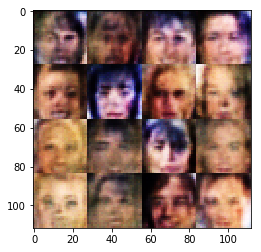

Epoch 1/1:   - Discriminator Loss: 1.3462:  - Generator Loss: 0.8688
Epoch 1/1:   - Discriminator Loss: 1.1713:  - Generator Loss: 0.7424
Epoch 1/1:   - Discriminator Loss: 1.3483:  - Generator Loss: 0.6907
Epoch 1/1:   - Discriminator Loss: 1.3417:  - Generator Loss: 0.6345
Epoch 1/1:   - Discriminator Loss: 1.1165:  - Generator Loss: 0.8393
Epoch 1/1:   - Discriminator Loss: 1.4742:  - Generator Loss: 0.6451
Epoch 1/1:   - Discriminator Loss: 1.2778:  - Generator Loss: 0.7939
Epoch 1/1:   - Discriminator Loss: 1.3018:  - Generator Loss: 0.6370
Epoch 1/1:   - Discriminator Loss: 1.2914:  - Generator Loss: 0.7265
Epoch 1/1:   - Discriminator Loss: 1.2372:  - Generator Loss: 0.8542


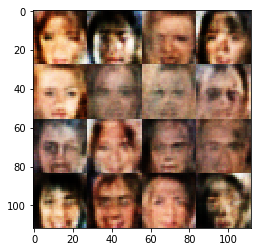

Epoch 1/1:   - Discriminator Loss: 1.3703:  - Generator Loss: 0.7556
Epoch 1/1:   - Discriminator Loss: 1.2875:  - Generator Loss: 0.6515
Epoch 1/1:   - Discriminator Loss: 1.1807:  - Generator Loss: 0.8001
Epoch 1/1:   - Discriminator Loss: 1.4571:  - Generator Loss: 0.6358
Epoch 1/1:   - Discriminator Loss: 1.4056:  - Generator Loss: 0.6682
Epoch 1/1:   - Discriminator Loss: 1.2723:  - Generator Loss: 0.6129
Epoch 1/1:   - Discriminator Loss: 1.3904:  - Generator Loss: 0.6239
Epoch 1/1:   - Discriminator Loss: 1.3485:  - Generator Loss: 0.6782
Epoch 1/1:   - Discriminator Loss: 1.3574:  - Generator Loss: 0.6671
Epoch 1/1:   - Discriminator Loss: 1.4174:  - Generator Loss: 0.6049


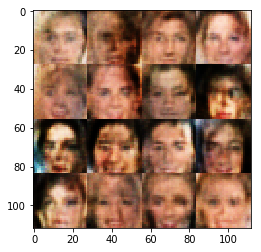

Epoch 1/1:   - Discriminator Loss: 1.3188:  - Generator Loss: 0.7062
Epoch 1/1:   - Discriminator Loss: 1.3945:  - Generator Loss: 0.6908
Epoch 1/1:   - Discriminator Loss: 1.5020:  - Generator Loss: 0.6018
Epoch 1/1:   - Discriminator Loss: 1.2327:  - Generator Loss: 0.8000
Epoch 1/1:   - Discriminator Loss: 1.4198:  - Generator Loss: 0.6532
Epoch 1/1:   - Discriminator Loss: 1.2126:  - Generator Loss: 0.8220
Epoch 1/1:   - Discriminator Loss: 1.3784:  - Generator Loss: 0.6946
Epoch 1/1:   - Discriminator Loss: 1.2995:  - Generator Loss: 0.6011
Epoch 1/1:   - Discriminator Loss: 1.4279:  - Generator Loss: 0.5734
Epoch 1/1:   - Discriminator Loss: 1.1917:  - Generator Loss: 0.7823


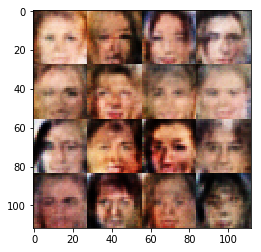

Epoch 1/1:   - Discriminator Loss: 1.5770:  - Generator Loss: 0.4632
Epoch 1/1:   - Discriminator Loss: 1.2790:  - Generator Loss: 0.7101
Epoch 1/1:   - Discriminator Loss: 1.2984:  - Generator Loss: 0.7427
Epoch 1/1:   - Discriminator Loss: 1.2893:  - Generator Loss: 0.6872
Epoch 1/1:   - Discriminator Loss: 1.3932:  - Generator Loss: 0.6737
Epoch 1/1:   - Discriminator Loss: 1.2411:  - Generator Loss: 0.7237
Epoch 1/1:   - Discriminator Loss: 1.3001:  - Generator Loss: 0.7692
Epoch 1/1:   - Discriminator Loss: 1.3055:  - Generator Loss: 0.7251
Epoch 1/1:   - Discriminator Loss: 1.1802:  - Generator Loss: 0.7804
Epoch 1/1:   - Discriminator Loss: 1.2022:  - Generator Loss: 0.7404


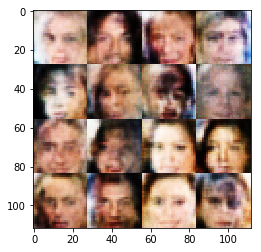

Epoch 1/1:   - Discriminator Loss: 1.1698:  - Generator Loss: 0.8743
Epoch 1/1:   - Discriminator Loss: 1.5069:  - Generator Loss: 0.5541
Epoch 1/1:   - Discriminator Loss: 1.3095:  - Generator Loss: 0.7559
Epoch 1/1:   - Discriminator Loss: 1.1465:  - Generator Loss: 0.9066
Epoch 1/1:   - Discriminator Loss: 1.3062:  - Generator Loss: 0.8249
Epoch 1/1:   - Discriminator Loss: 1.3063:  - Generator Loss: 0.6591
Epoch 1/1:   - Discriminator Loss: 1.3148:  - Generator Loss: 0.6944
Epoch 1/1:   - Discriminator Loss: 1.2835:  - Generator Loss: 0.6525
Epoch 1/1:   - Discriminator Loss: 1.3403:  - Generator Loss: 0.5868
Epoch 1/1:   - Discriminator Loss: 1.3148:  - Generator Loss: 0.8029


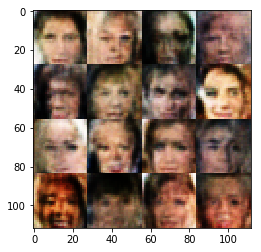

Epoch 1/1:   - Discriminator Loss: 1.4846:  - Generator Loss: 0.5538
Epoch 1/1:   - Discriminator Loss: 1.2325:  - Generator Loss: 0.7739
Epoch 1/1:   - Discriminator Loss: 1.3027:  - Generator Loss: 0.8011
Epoch 1/1:   - Discriminator Loss: 1.0255:  - Generator Loss: 0.9351
Epoch 1/1:   - Discriminator Loss: 1.1112:  - Generator Loss: 0.7717
Epoch 1/1:   - Discriminator Loss: 1.3030:  - Generator Loss: 0.8145
Epoch 1/1:   - Discriminator Loss: 1.3061:  - Generator Loss: 0.7028
Epoch 1/1:   - Discriminator Loss: 1.2096:  - Generator Loss: 0.8682
Epoch 1/1:   - Discriminator Loss: 1.3300:  - Generator Loss: 0.7131
Epoch 1/1:   - Discriminator Loss: 1.1998:  - Generator Loss: 0.9216


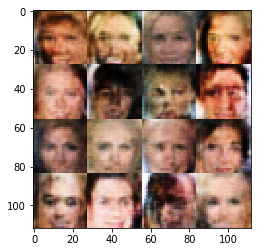

Epoch 1/1:   - Discriminator Loss: 1.1551:  - Generator Loss: 0.9359
Epoch 1/1:   - Discriminator Loss: 1.4108:  - Generator Loss: 0.5701
Epoch 1/1:   - Discriminator Loss: 1.2672:  - Generator Loss: 0.6833
Epoch 1/1:   - Discriminator Loss: 1.3000:  - Generator Loss: 0.6629
Epoch 1/1:   - Discriminator Loss: 1.4262:  - Generator Loss: 0.6058
Epoch 1/1:   - Discriminator Loss: 1.6353:  - Generator Loss: 0.5633
Epoch 1/1:   - Discriminator Loss: 1.1051:  - Generator Loss: 0.7696
Epoch 1/1:   - Discriminator Loss: 1.0845:  - Generator Loss: 0.8098
Epoch 1/1:   - Discriminator Loss: 1.0950:  - Generator Loss: 0.8362
Epoch 1/1:   - Discriminator Loss: 1.3899:  - Generator Loss: 0.6793


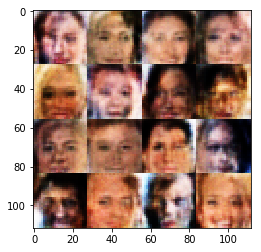

Epoch 1/1:   - Discriminator Loss: 1.3678:  - Generator Loss: 0.6543
Epoch 1/1:   - Discriminator Loss: 1.3708:  - Generator Loss: 0.6788
Epoch 1/1:   - Discriminator Loss: 1.2212:  - Generator Loss: 0.7890
Epoch 1/1:   - Discriminator Loss: 1.5001:  - Generator Loss: 0.5674
Epoch 1/1:   - Discriminator Loss: 1.3256:  - Generator Loss: 0.6804
Epoch 1/1:   - Discriminator Loss: 1.3378:  - Generator Loss: 0.6696
Epoch 1/1:   - Discriminator Loss: 1.3430:  - Generator Loss: 0.7313
Epoch 1/1:   - Discriminator Loss: 1.6045:  - Generator Loss: 0.4918
Epoch 1/1:   - Discriminator Loss: 1.7604:  - Generator Loss: 0.5409
Epoch 1/1:   - Discriminator Loss: 0.9925:  - Generator Loss: 0.9999


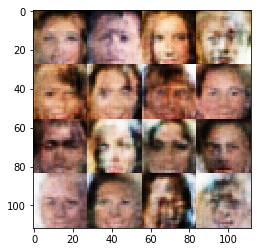

Epoch 1/1:   - Discriminator Loss: 1.2500:  - Generator Loss: 0.7576
Epoch 1/1:   - Discriminator Loss: 1.3588:  - Generator Loss: 0.7916
Epoch 1/1:   - Discriminator Loss: 1.1832:  - Generator Loss: 0.7241
Epoch 1/1:   - Discriminator Loss: 1.1756:  - Generator Loss: 0.7554
Epoch 1/1:   - Discriminator Loss: 1.1069:  - Generator Loss: 0.8795
Epoch 1/1:   - Discriminator Loss: 1.2522:  - Generator Loss: 0.7481
Epoch 1/1:   - Discriminator Loss: 1.3732:  - Generator Loss: 0.6861
Epoch 1/1:   - Discriminator Loss: 1.1752:  - Generator Loss: 0.8149
Epoch 1/1:   - Discriminator Loss: 1.3848:  - Generator Loss: 0.6386
Epoch 1/1:   - Discriminator Loss: 1.4224:  - Generator Loss: 0.6055


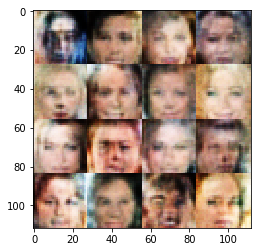

Epoch 1/1:   - Discriminator Loss: 1.4049:  - Generator Loss: 0.7120
Epoch 1/1:   - Discriminator Loss: 1.2061:  - Generator Loss: 0.8079
Epoch 1/1:   - Discriminator Loss: 1.1888:  - Generator Loss: 0.8730
Epoch 1/1:   - Discriminator Loss: 1.3946:  - Generator Loss: 0.5878
Epoch 1/1:   - Discriminator Loss: 1.3207:  - Generator Loss: 0.7414
Epoch 1/1:   - Discriminator Loss: 1.0710:  - Generator Loss: 0.8217
Epoch 1/1:   - Discriminator Loss: 1.3058:  - Generator Loss: 0.6802
Epoch 1/1:   - Discriminator Loss: 1.3175:  - Generator Loss: 0.8107
Epoch 1/1:   - Discriminator Loss: 1.0898:  - Generator Loss: 0.8495
Epoch 1/1:   - Discriminator Loss: 1.2382:  - Generator Loss: 0.7321


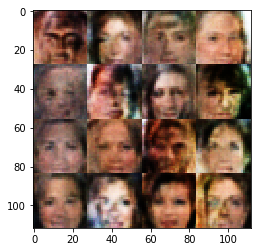

Epoch 1/1:   - Discriminator Loss: 1.2259:  - Generator Loss: 0.8074
Epoch 1/1:   - Discriminator Loss: 1.5660:  - Generator Loss: 0.6766
Epoch 1/1:   - Discriminator Loss: 1.2985:  - Generator Loss: 0.7606
Epoch 1/1:   - Discriminator Loss: 1.1721:  - Generator Loss: 0.6917
Epoch 1/1:   - Discriminator Loss: 1.0322:  - Generator Loss: 0.8706
Epoch 1/1:   - Discriminator Loss: 1.1382:  - Generator Loss: 0.8193
Epoch 1/1:   - Discriminator Loss: 1.4032:  - Generator Loss: 0.7256
Epoch 1/1:   - Discriminator Loss: 1.1972:  - Generator Loss: 0.8346
Epoch 1/1:   - Discriminator Loss: 1.0415:  - Generator Loss: 0.8279
Epoch 1/1:   - Discriminator Loss: 1.2970:  - Generator Loss: 0.8443


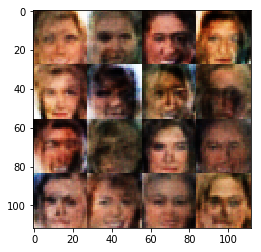

Epoch 1/1:   - Discriminator Loss: 1.3700:  - Generator Loss: 0.7471
Epoch 1/1:   - Discriminator Loss: 0.9889:  - Generator Loss: 0.8446
Epoch 1/1:   - Discriminator Loss: 1.0892:  - Generator Loss: 0.7976
Epoch 1/1:   - Discriminator Loss: 1.4814:  - Generator Loss: 0.6504
Epoch 1/1:   - Discriminator Loss: 1.3589:  - Generator Loss: 0.6889
Epoch 1/1:   - Discriminator Loss: 1.1404:  - Generator Loss: 0.8523
Epoch 1/1:   - Discriminator Loss: 1.1669:  - Generator Loss: 0.8123
Epoch 1/1:   - Discriminator Loss: 1.4660:  - Generator Loss: 0.5808
Epoch 1/1:   - Discriminator Loss: 1.2537:  - Generator Loss: 0.9094
Epoch 1/1:   - Discriminator Loss: 1.3230:  - Generator Loss: 0.6887


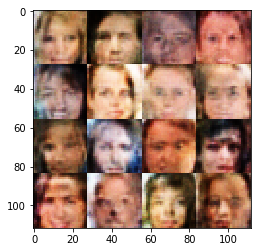

Epoch 1/1:   - Discriminator Loss: 1.1471:  - Generator Loss: 0.9745
Epoch 1/1:   - Discriminator Loss: 1.3321:  - Generator Loss: 0.6213
Epoch 1/1:   - Discriminator Loss: 1.2166:  - Generator Loss: 0.7281
Epoch 1/1:   - Discriminator Loss: 1.2933:  - Generator Loss: 0.6645
Epoch 1/1:   - Discriminator Loss: 1.3713:  - Generator Loss: 0.7018
Epoch 1/1:   - Discriminator Loss: 1.4119:  - Generator Loss: 0.6984
Epoch 1/1:   - Discriminator Loss: 1.3845:  - Generator Loss: 0.7848
Epoch 1/1:   - Discriminator Loss: 1.0074:  - Generator Loss: 1.0616
Epoch 1/1:   - Discriminator Loss: 1.5372:  - Generator Loss: 0.5695
Epoch 1/1:   - Discriminator Loss: 1.3025:  - Generator Loss: 0.6466


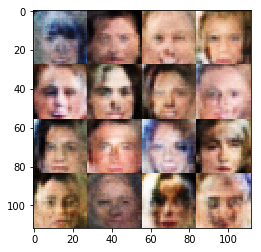

Epoch 1/1:   - Discriminator Loss: 1.2720:  - Generator Loss: 0.8095
Epoch 1/1:   - Discriminator Loss: 1.3040:  - Generator Loss: 0.7183
Epoch 1/1:   - Discriminator Loss: 1.3635:  - Generator Loss: 0.5856
Epoch 1/1:   - Discriminator Loss: 1.1122:  - Generator Loss: 0.7428
Epoch 1/1:   - Discriminator Loss: 1.3039:  - Generator Loss: 0.7050
Epoch 1/1:   - Discriminator Loss: 1.1267:  - Generator Loss: 0.9103
Epoch 1/1:   - Discriminator Loss: 1.1401:  - Generator Loss: 0.9490
Epoch 1/1:   - Discriminator Loss: 1.2528:  - Generator Loss: 0.7470
Epoch 1/1:   - Discriminator Loss: 1.2684:  - Generator Loss: 0.6570
Epoch 1/1:   - Discriminator Loss: 1.2627:  - Generator Loss: 0.8111


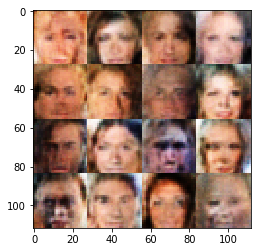

Epoch 1/1:   - Discriminator Loss: 1.4109:  - Generator Loss: 0.6116
Epoch 1/1:   - Discriminator Loss: 1.2579:  - Generator Loss: 0.7685
Epoch 1/1:   - Discriminator Loss: 1.4818:  - Generator Loss: 0.5991
Epoch 1/1:   - Discriminator Loss: 1.2078:  - Generator Loss: 0.9236
Epoch 1/1:   - Discriminator Loss: 1.4247:  - Generator Loss: 0.6611
Epoch 1/1:   - Discriminator Loss: 1.5121:  - Generator Loss: 0.6605
Epoch 1/1:   - Discriminator Loss: 1.3056:  - Generator Loss: 0.6581
Epoch 1/1:   - Discriminator Loss: 1.1826:  - Generator Loss: 0.8008
Epoch 1/1:   - Discriminator Loss: 1.1605:  - Generator Loss: 1.0337
Epoch 1/1:   - Discriminator Loss: 1.1345:  - Generator Loss: 0.7714


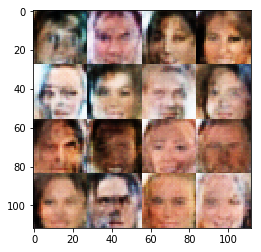

Epoch 1/1:   - Discriminator Loss: 1.2309:  - Generator Loss: 0.6756
Epoch 1/1:   - Discriminator Loss: 1.3833:  - Generator Loss: 0.6692
Epoch 1/1:   - Discriminator Loss: 1.2535:  - Generator Loss: 0.7925
Epoch 1/1:   - Discriminator Loss: 1.0939:  - Generator Loss: 0.9412
Epoch 1/1:   - Discriminator Loss: 1.4416:  - Generator Loss: 0.6086
Epoch 1/1:   - Discriminator Loss: 0.8345:  - Generator Loss: 1.3472
Epoch 1/1:   - Discriminator Loss: 1.1791:  - Generator Loss: 0.8863
Epoch 1/1:   - Discriminator Loss: 1.2498:  - Generator Loss: 0.7811
Epoch 1/1:   - Discriminator Loss: 1.1493:  - Generator Loss: 0.8495
Epoch 1/1:   - Discriminator Loss: 1.4451:  - Generator Loss: 0.7321


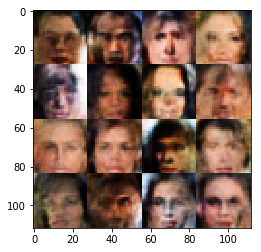

Epoch 1/1:   - Discriminator Loss: 1.3392:  - Generator Loss: 0.6212
Epoch 1/1:   - Discriminator Loss: 1.1806:  - Generator Loss: 0.7145
Epoch 1/1:   - Discriminator Loss: 1.1777:  - Generator Loss: 0.7680
Epoch 1/1:   - Discriminator Loss: 1.2841:  - Generator Loss: 0.7228
Epoch 1/1:   - Discriminator Loss: 1.2286:  - Generator Loss: 0.6910
Epoch 1/1:   - Discriminator Loss: 1.2531:  - Generator Loss: 0.9142
Epoch 1/1:   - Discriminator Loss: 1.4314:  - Generator Loss: 0.7204
Epoch 1/1:   - Discriminator Loss: 1.4777:  - Generator Loss: 0.5624
Epoch 1/1:   - Discriminator Loss: 1.4034:  - Generator Loss: 0.6868
Epoch 1/1:   - Discriminator Loss: 1.2993:  - Generator Loss: 0.7404


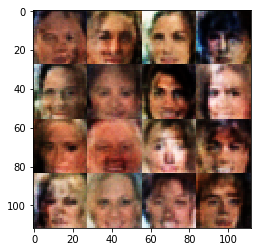

Epoch 1/1:   - Discriminator Loss: 1.8588:  - Generator Loss: 0.4367
Epoch 1/1:   - Discriminator Loss: 1.6673:  - Generator Loss: 0.5748
Epoch 1/1:   - Discriminator Loss: 1.1039:  - Generator Loss: 0.8574
Epoch 1/1:   - Discriminator Loss: 1.2720:  - Generator Loss: 0.8182
Epoch 1/1:   - Discriminator Loss: 1.2450:  - Generator Loss: 0.7215
Epoch 1/1:   - Discriminator Loss: 1.5621:  - Generator Loss: 0.6340
Epoch 1/1:   - Discriminator Loss: 1.1823:  - Generator Loss: 0.8588
Epoch 1/1:   - Discriminator Loss: 1.3672:  - Generator Loss: 0.6988
Epoch 1/1:   - Discriminator Loss: 1.3522:  - Generator Loss: 0.6425
Epoch 1/1:   - Discriminator Loss: 1.3891:  - Generator Loss: 0.6701


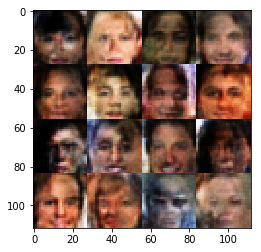

Epoch 1/1:   - Discriminator Loss: 1.2332:  - Generator Loss: 0.8182
Epoch 1/1:   - Discriminator Loss: 1.5495:  - Generator Loss: 0.5417
Epoch 1/1:   - Discriminator Loss: 1.2919:  - Generator Loss: 0.7247
Epoch 1/1:   - Discriminator Loss: 1.2805:  - Generator Loss: 0.7072
Epoch 1/1:   - Discriminator Loss: 1.4999:  - Generator Loss: 0.6816
Epoch 1/1:   - Discriminator Loss: 1.1900:  - Generator Loss: 0.8799
Epoch 1/1:   - Discriminator Loss: 1.3714:  - Generator Loss: 0.5756
Epoch 1/1:   - Discriminator Loss: 1.3137:  - Generator Loss: 0.6543
Epoch 1/1:   - Discriminator Loss: 1.2103:  - Generator Loss: 0.6977
Epoch 1/1:   - Discriminator Loss: 1.1424:  - Generator Loss: 0.7624


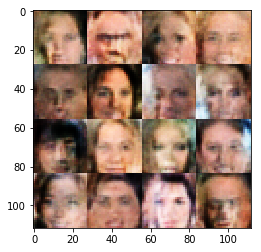

Epoch 1/1:   - Discriminator Loss: 1.5065:  - Generator Loss: 0.4952
Epoch 1/1:   - Discriminator Loss: 1.3012:  - Generator Loss: 0.7100
Epoch 1/1:   - Discriminator Loss: 1.3674:  - Generator Loss: 0.6535
Epoch 1/1:   - Discriminator Loss: 1.2402:  - Generator Loss: 0.8312
Epoch 1/1:   - Discriminator Loss: 1.3824:  - Generator Loss: 0.6424
Epoch 1/1:   - Discriminator Loss: 1.2605:  - Generator Loss: 0.7098
Epoch 1/1:   - Discriminator Loss: 1.3579:  - Generator Loss: 0.5900
Epoch 1/1:   - Discriminator Loss: 1.1636:  - Generator Loss: 0.9408
Epoch 1/1:   - Discriminator Loss: 1.2003:  - Generator Loss: 0.8678
Epoch 1/1:   - Discriminator Loss: 1.1033:  - Generator Loss: 0.8748


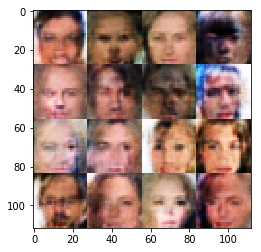

Epoch 1/1:   - Discriminator Loss: 1.4735:  - Generator Loss: 0.6007
Epoch 1/1:   - Discriminator Loss: 1.5483:  - Generator Loss: 0.6779
Epoch 1/1:   - Discriminator Loss: 1.2356:  - Generator Loss: 0.9430
Epoch 1/1:   - Discriminator Loss: 1.4540:  - Generator Loss: 0.7065
Epoch 1/1:   - Discriminator Loss: 1.2413:  - Generator Loss: 0.6242
Epoch 1/1:   - Discriminator Loss: 1.4496:  - Generator Loss: 0.5366
Epoch 1/1:   - Discriminator Loss: 1.3004:  - Generator Loss: 0.7288
Epoch 1/1:   - Discriminator Loss: 1.2971:  - Generator Loss: 0.7947
Epoch 1/1:   - Discriminator Loss: 1.3276:  - Generator Loss: 0.6838
Epoch 1/1:   - Discriminator Loss: 1.4971:  - Generator Loss: 0.5776


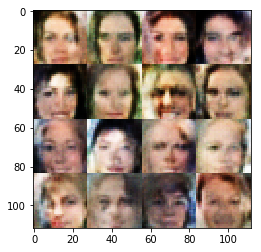

Epoch 1/1:   - Discriminator Loss: 1.4611:  - Generator Loss: 0.5226
Epoch 1/1:   - Discriminator Loss: 1.3013:  - Generator Loss: 0.7185
Epoch 1/1:   - Discriminator Loss: 1.2994:  - Generator Loss: 0.6033
Epoch 1/1:   - Discriminator Loss: 1.5760:  - Generator Loss: 0.4861
Epoch 1/1:   - Discriminator Loss: 1.2917:  - Generator Loss: 0.7437
Epoch 1/1:   - Discriminator Loss: 1.3612:  - Generator Loss: 0.6406
Epoch 1/1:   - Discriminator Loss: 1.1695:  - Generator Loss: 0.7737
Epoch 1/1:   - Discriminator Loss: 1.2486:  - Generator Loss: 0.7280
Epoch 1/1:   - Discriminator Loss: 1.2315:  - Generator Loss: 0.8351
Epoch 1/1:   - Discriminator Loss: 1.3008:  - Generator Loss: 0.6694


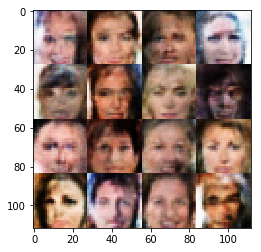

Epoch 1/1:   - Discriminator Loss: 1.2833:  - Generator Loss: 0.7342
Epoch 1/1:   - Discriminator Loss: 1.4090:  - Generator Loss: 0.6884
Epoch 1/1:   - Discriminator Loss: 1.2389:  - Generator Loss: 0.7242
Epoch 1/1:   - Discriminator Loss: 1.2531:  - Generator Loss: 0.8402
Epoch 1/1:   - Discriminator Loss: 1.3505:  - Generator Loss: 0.6722
Epoch 1/1:   - Discriminator Loss: 1.3752:  - Generator Loss: 0.7603
Epoch 1/1:   - Discriminator Loss: 1.3367:  - Generator Loss: 0.7811
Epoch 1/1:   - Discriminator Loss: 1.1510:  - Generator Loss: 0.8226
Epoch 1/1:   - Discriminator Loss: 1.0777:  - Generator Loss: 0.7423
Epoch 1/1:   - Discriminator Loss: 1.2085:  - Generator Loss: 0.6334


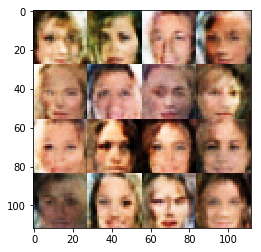

Epoch 1/1:   - Discriminator Loss: 1.2288:  - Generator Loss: 0.7491
Epoch 1/1:   - Discriminator Loss: 1.4022:  - Generator Loss: 0.6890
Epoch 1/1:   - Discriminator Loss: 1.2546:  - Generator Loss: 0.7524
Epoch 1/1:   - Discriminator Loss: 1.2836:  - Generator Loss: 0.6673
Epoch 1/1:   - Discriminator Loss: 1.2159:  - Generator Loss: 0.7483
Epoch 1/1:   - Discriminator Loss: 1.1038:  - Generator Loss: 0.8368
Epoch 1/1:   - Discriminator Loss: 1.4563:  - Generator Loss: 0.6439
Epoch 1/1:   - Discriminator Loss: 1.1560:  - Generator Loss: 0.7520
Epoch 1/1:   - Discriminator Loss: 1.2892:  - Generator Loss: 0.7411
Epoch 1/1:   - Discriminator Loss: 1.4489:  - Generator Loss: 0.5553


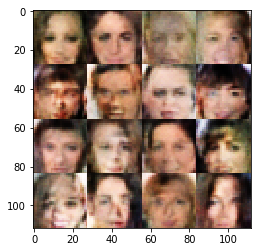

Epoch 1/1:   - Discriminator Loss: 1.5654:  - Generator Loss: 0.5065
Epoch 1/1:   - Discriminator Loss: 0.8499:  - Generator Loss: 1.1743
Epoch 1/1:   - Discriminator Loss: 1.3012:  - Generator Loss: 0.8383
Epoch 1/1:   - Discriminator Loss: 1.3762:  - Generator Loss: 0.5045
Epoch 1/1:   - Discriminator Loss: 1.2885:  - Generator Loss: 0.7837
Epoch 1/1:   - Discriminator Loss: 1.1587:  - Generator Loss: 0.7947
Epoch 1/1:   - Discriminator Loss: 1.3567:  - Generator Loss: 0.6658
Epoch 1/1:   - Discriminator Loss: 1.3753:  - Generator Loss: 0.5405
Epoch 1/1:   - Discriminator Loss: 1.3047:  - Generator Loss: 0.6869
Epoch 1/1:   - Discriminator Loss: 1.2319:  - Generator Loss: 0.8620


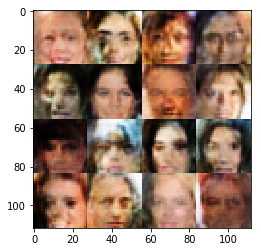

Epoch 1/1:   - Discriminator Loss: 1.4501:  - Generator Loss: 0.5717
Epoch 1/1:   - Discriminator Loss: 1.3428:  - Generator Loss: 0.6653
Epoch 1/1:   - Discriminator Loss: 1.3768:  - Generator Loss: 0.6718
Epoch 1/1:   - Discriminator Loss: 1.1657:  - Generator Loss: 0.7754
Epoch 1/1:   - Discriminator Loss: 1.2963:  - Generator Loss: 0.7439
Epoch 1/1:   - Discriminator Loss: 1.2812:  - Generator Loss: 0.8329
Epoch 1/1:   - Discriminator Loss: 1.1777:  - Generator Loss: 0.7834
Epoch 1/1:   - Discriminator Loss: 1.3856:  - Generator Loss: 0.5899
Epoch 1/1:   - Discriminator Loss: 1.7722:  - Generator Loss: 0.3655
Epoch 1/1:   - Discriminator Loss: 1.2282:  - Generator Loss: 0.6963


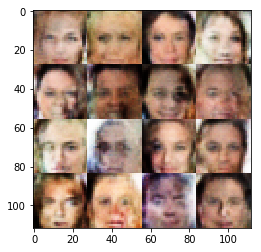

Epoch 1/1:   - Discriminator Loss: 1.1967:  - Generator Loss: 0.7049
Epoch 1/1:   - Discriminator Loss: 1.3276:  - Generator Loss: 0.6067
Epoch 1/1:   - Discriminator Loss: 1.3659:  - Generator Loss: 0.6100
Epoch 1/1:   - Discriminator Loss: 1.0882:  - Generator Loss: 0.8298
Epoch 1/1:   - Discriminator Loss: 1.3046:  - Generator Loss: 0.9282
Epoch 1/1:   - Discriminator Loss: 1.1822:  - Generator Loss: 0.8469
Epoch 1/1:   - Discriminator Loss: 1.2607:  - Generator Loss: 0.6194
Epoch 1/1:   - Discriminator Loss: 1.5778:  - Generator Loss: 0.6077
Epoch 1/1:   - Discriminator Loss: 0.9645:  - Generator Loss: 0.9330
Epoch 1/1:   - Discriminator Loss: 1.3182:  - Generator Loss: 0.6935


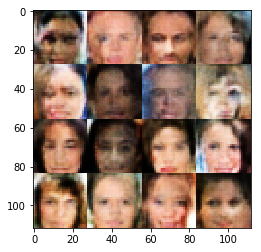

Epoch 1/1:   - Discriminator Loss: 1.4240:  - Generator Loss: 0.6261
Epoch 1/1:   - Discriminator Loss: 1.2732:  - Generator Loss: 0.8519
Epoch 1/1:   - Discriminator Loss: 1.4731:  - Generator Loss: 0.5586
Epoch 1/1:   - Discriminator Loss: 1.4116:  - Generator Loss: 0.5953
Epoch 1/1:   - Discriminator Loss: 1.2981:  - Generator Loss: 0.7015
Epoch 1/1:   - Discriminator Loss: 1.0455:  - Generator Loss: 0.7936
Epoch 1/1:   - Discriminator Loss: 1.5246:  - Generator Loss: 0.4946
Epoch 1/1:   - Discriminator Loss: 1.2299:  - Generator Loss: 0.7775
Epoch 1/1:   - Discriminator Loss: 1.3131:  - Generator Loss: 0.7925
Epoch 1/1:   - Discriminator Loss: 1.4163:  - Generator Loss: 0.7996


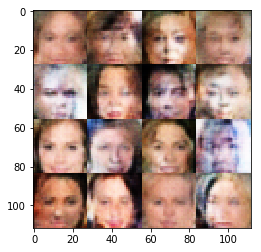

Epoch 1/1:   - Discriminator Loss: 1.1843:  - Generator Loss: 0.7610
Epoch 1/1:   - Discriminator Loss: 1.5073:  - Generator Loss: 0.6576
Epoch 1/1:   - Discriminator Loss: 1.2494:  - Generator Loss: 0.8731
Epoch 1/1:   - Discriminator Loss: 1.1650:  - Generator Loss: 0.7586
Epoch 1/1:   - Discriminator Loss: 1.3210:  - Generator Loss: 0.6237
Epoch 1/1:   - Discriminator Loss: 1.2517:  - Generator Loss: 0.7645
Epoch 1/1:   - Discriminator Loss: 1.3104:  - Generator Loss: 0.6647
Epoch 1/1:   - Discriminator Loss: 1.3479:  - Generator Loss: 0.6627
Epoch 1/1:   - Discriminator Loss: 1.5627:  - Generator Loss: 0.6791
Epoch 1/1:   - Discriminator Loss: 1.4560:  - Generator Loss: 0.5349


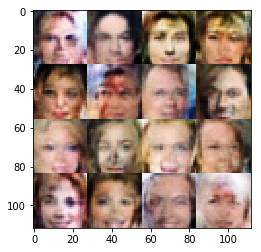

Epoch 1/1:   - Discriminator Loss: 0.9899:  - Generator Loss: 0.8634
Epoch 1/1:   - Discriminator Loss: 1.5598:  - Generator Loss: 0.6031
Epoch 1/1:   - Discriminator Loss: 1.3279:  - Generator Loss: 0.6852
Epoch 1/1:   - Discriminator Loss: 1.2173:  - Generator Loss: 0.7183
Epoch 1/1:   - Discriminator Loss: 1.2899:  - Generator Loss: 0.7456
Epoch 1/1:   - Discriminator Loss: 1.3477:  - Generator Loss: 0.6995
Epoch 1/1:   - Discriminator Loss: 1.2347:  - Generator Loss: 0.6150
Epoch 1/1:   - Discriminator Loss: 1.2806:  - Generator Loss: 0.7301
Epoch 1/1:   - Discriminator Loss: 1.2574:  - Generator Loss: 0.6996
Epoch 1/1:   - Discriminator Loss: 1.1296:  - Generator Loss: 0.8588


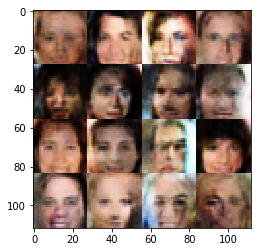

Epoch 1/1:   - Discriminator Loss: 1.2581:  - Generator Loss: 0.7121
Epoch 1/1:   - Discriminator Loss: 1.2119:  - Generator Loss: 0.7506
Epoch 1/1:   - Discriminator Loss: 1.4134:  - Generator Loss: 0.5505
Epoch 1/1:   - Discriminator Loss: 1.5197:  - Generator Loss: 0.5987
Epoch 1/1:   - Discriminator Loss: 1.3757:  - Generator Loss: 0.6046
Epoch 1/1:   - Discriminator Loss: 1.2879:  - Generator Loss: 0.6566
Epoch 1/1:   - Discriminator Loss: 1.3422:  - Generator Loss: 0.5161
Epoch 1/1:   - Discriminator Loss: 1.2102:  - Generator Loss: 0.7492
Epoch 1/1:   - Discriminator Loss: 1.4432:  - Generator Loss: 0.7105
Epoch 1/1:   - Discriminator Loss: 1.1421:  - Generator Loss: 0.9152


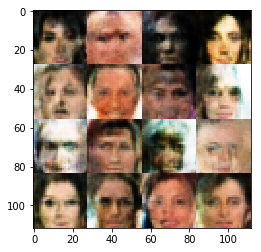

Epoch 1/1:   - Discriminator Loss: 1.3089:  - Generator Loss: 0.7003
Epoch 1/1:   - Discriminator Loss: 1.0969:  - Generator Loss: 0.8092
Epoch 1/1:   - Discriminator Loss: 1.2148:  - Generator Loss: 0.8060
Epoch 1/1:   - Discriminator Loss: 1.4310:  - Generator Loss: 0.7766
Epoch 1/1:   - Discriminator Loss: 1.1962:  - Generator Loss: 0.7904
Epoch 1/1:   - Discriminator Loss: 1.4798:  - Generator Loss: 0.5522
Epoch 1/1:   - Discriminator Loss: 1.4438:  - Generator Loss: 0.5790
Epoch 1/1:   - Discriminator Loss: 1.3951:  - Generator Loss: 0.6645
Epoch 1/1:   - Discriminator Loss: 1.2696:  - Generator Loss: 0.6631
Epoch 1/1:   - Discriminator Loss: 1.4275:  - Generator Loss: 0.6681


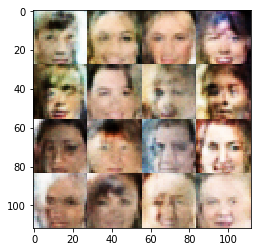

Epoch 1/1:   - Discriminator Loss: 1.3329:  - Generator Loss: 0.6739
Epoch 1/1:   - Discriminator Loss: 1.1385:  - Generator Loss: 0.7458
Epoch 1/1:   - Discriminator Loss: 1.3710:  - Generator Loss: 0.6227
Epoch 1/1:   - Discriminator Loss: 1.2265:  - Generator Loss: 0.7612
Epoch 1/1:   - Discriminator Loss: 1.1875:  - Generator Loss: 0.8503
Epoch 1/1:   - Discriminator Loss: 1.3367:  - Generator Loss: 0.6552
Epoch 1/1:   - Discriminator Loss: 1.2019:  - Generator Loss: 0.7945
Epoch 1/1:   - Discriminator Loss: 1.2234:  - Generator Loss: 0.7728
Epoch 1/1:   - Discriminator Loss: 1.2483:  - Generator Loss: 0.8110
Epoch 1/1:   - Discriminator Loss: 1.0403:  - Generator Loss: 0.8213


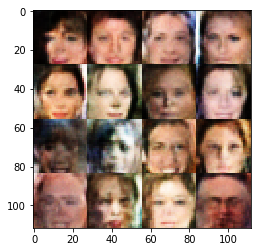

Epoch 1/1:   - Discriminator Loss: 1.3423:  - Generator Loss: 0.6655
Epoch 1/1:   - Discriminator Loss: 1.2273:  - Generator Loss: 0.8884
Epoch 1/1:   - Discriminator Loss: 1.0730:  - Generator Loss: 0.8822
Epoch 1/1:   - Discriminator Loss: 1.3104:  - Generator Loss: 0.6379
Epoch 1/1:   - Discriminator Loss: 1.2532:  - Generator Loss: 0.7236
Epoch 1/1:   - Discriminator Loss: 1.3377:  - Generator Loss: 0.6647
Epoch 1/1:   - Discriminator Loss: 1.0899:  - Generator Loss: 0.8213
Epoch 1/1:   - Discriminator Loss: 1.3982:  - Generator Loss: 0.6351
Epoch 1/1:   - Discriminator Loss: 1.5205:  - Generator Loss: 0.5359
Epoch 1/1:   - Discriminator Loss: 1.3390:  - Generator Loss: 0.6135


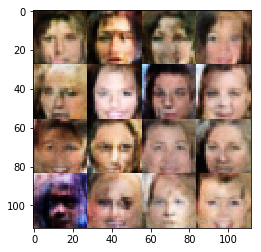

Epoch 1/1:   - Discriminator Loss: 1.2251:  - Generator Loss: 0.8325
Epoch 1/1:   - Discriminator Loss: 1.3668:  - Generator Loss: 0.7202
Epoch 1/1:   - Discriminator Loss: 1.2274:  - Generator Loss: 0.8471
Epoch 1/1:   - Discriminator Loss: 1.4071:  - Generator Loss: 0.5603
Epoch 1/1:   - Discriminator Loss: 1.2181:  - Generator Loss: 0.7893
Epoch 1/1:   - Discriminator Loss: 1.1922:  - Generator Loss: 0.8107
Epoch 1/1:   - Discriminator Loss: 1.1730:  - Generator Loss: 0.6818
Epoch 1/1:   - Discriminator Loss: 1.2162:  - Generator Loss: 0.7388
Epoch 1/1:   - Discriminator Loss: 1.2055:  - Generator Loss: 0.6659
Epoch 1/1:   - Discriminator Loss: 1.3030:  - Generator Loss: 0.8262


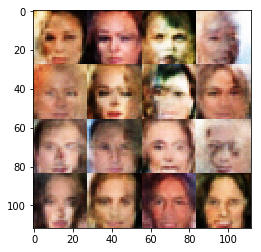

Epoch 1/1:   - Discriminator Loss: 1.3423:  - Generator Loss: 0.7225
Epoch 1/1:   - Discriminator Loss: 1.2447:  - Generator Loss: 0.6623
Epoch 1/1:   - Discriminator Loss: 1.0999:  - Generator Loss: 0.9692
Epoch 1/1:   - Discriminator Loss: 1.1947:  - Generator Loss: 0.7659
Epoch 1/1:   - Discriminator Loss: 1.0980:  - Generator Loss: 0.8927
Epoch 1/1:   - Discriminator Loss: 1.6079:  - Generator Loss: 0.5174
Epoch 1/1:   - Discriminator Loss: 1.2332:  - Generator Loss: 0.7969
Epoch 1/1:   - Discriminator Loss: 1.2207:  - Generator Loss: 0.8401
Epoch 1/1:   - Discriminator Loss: 1.2956:  - Generator Loss: 0.6609
Epoch 1/1:   - Discriminator Loss: 1.1552:  - Generator Loss: 0.7793


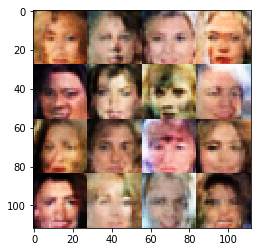

Epoch 1/1:   - Discriminator Loss: 1.2847:  - Generator Loss: 0.7237
Epoch 1/1:   - Discriminator Loss: 1.1802:  - Generator Loss: 0.7510
Epoch 1/1:   - Discriminator Loss: 1.1877:  - Generator Loss: 0.7574
Epoch 1/1:   - Discriminator Loss: 1.2557:  - Generator Loss: 0.6931
Epoch 1/1:   - Discriminator Loss: 1.3062:  - Generator Loss: 0.6056
Epoch 1/1:   - Discriminator Loss: 1.1064:  - Generator Loss: 0.9111
Epoch 1/1:   - Discriminator Loss: 1.4333:  - Generator Loss: 0.6243
Epoch 1/1:   - Discriminator Loss: 1.5309:  - Generator Loss: 0.5259
Epoch 1/1:   - Discriminator Loss: 1.2308:  - Generator Loss: 0.8535
Epoch 1/1:   - Discriminator Loss: 1.3964:  - Generator Loss: 0.7757


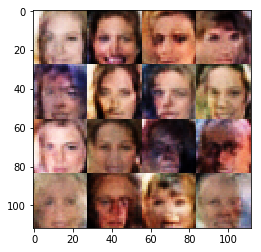

Epoch 1/1:   - Discriminator Loss: 1.1221:  - Generator Loss: 0.6733
Epoch 1/1:   - Discriminator Loss: 1.0889:  - Generator Loss: 0.7661
Epoch 1/1:   - Discriminator Loss: 1.2045:  - Generator Loss: 0.7017
Epoch 1/1:   - Discriminator Loss: 0.9497:  - Generator Loss: 0.9051
Epoch 1/1:   - Discriminator Loss: 1.2851:  - Generator Loss: 0.6887
Epoch 1/1:   - Discriminator Loss: 1.1648:  - Generator Loss: 0.6884
Epoch 1/1:   - Discriminator Loss: 1.1262:  - Generator Loss: 0.7372
Epoch 1/1:   - Discriminator Loss: 1.1316:  - Generator Loss: 0.6859
Epoch 1/1:   - Discriminator Loss: 1.5133:  - Generator Loss: 0.5416
Epoch 1/1:   - Discriminator Loss: 1.2437:  - Generator Loss: 0.7298


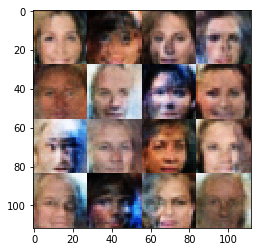

Epoch 1/1:   - Discriminator Loss: 1.3498:  - Generator Loss: 0.6074
Epoch 1/1:   - Discriminator Loss: 1.5022:  - Generator Loss: 0.6586
Epoch 1/1:   - Discriminator Loss: 1.2999:  - Generator Loss: 0.6038
Epoch 1/1:   - Discriminator Loss: 1.3842:  - Generator Loss: 0.5456
Epoch 1/1:   - Discriminator Loss: 1.3756:  - Generator Loss: 0.6731
Epoch 1/1:   - Discriminator Loss: 1.3693:  - Generator Loss: 0.6760
Epoch 1/1:   - Discriminator Loss: 1.4488:  - Generator Loss: 0.6287
Epoch 1/1:   - Discriminator Loss: 1.4833:  - Generator Loss: 0.8413
Epoch 1/1:   - Discriminator Loss: 1.4364:  - Generator Loss: 0.6963
Epoch 1/1:   - Discriminator Loss: 1.3113:  - Generator Loss: 0.6952


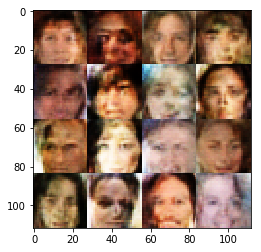

Epoch 1/1:   - Discriminator Loss: 1.2136:  - Generator Loss: 0.7688
Epoch 1/1:   - Discriminator Loss: 1.3013:  - Generator Loss: 0.6768
Epoch 1/1:   - Discriminator Loss: 1.2353:  - Generator Loss: 0.7891
Epoch 1/1:   - Discriminator Loss: 1.2310:  - Generator Loss: 0.7574
Epoch 1/1:   - Discriminator Loss: 1.1717:  - Generator Loss: 0.7794
Epoch 1/1:   - Discriminator Loss: 1.2972:  - Generator Loss: 0.7538
Epoch 1/1:   - Discriminator Loss: 1.4268:  - Generator Loss: 0.4986
Epoch 1/1:   - Discriminator Loss: 1.3176:  - Generator Loss: 0.7425
Epoch 1/1:   - Discriminator Loss: 1.1567:  - Generator Loss: 0.7220
Epoch 1/1:   - Discriminator Loss: 1.3339:  - Generator Loss: 0.5661


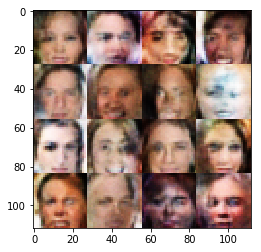

Epoch 1/1:   - Discriminator Loss: 1.0274:  - Generator Loss: 0.9008
Epoch 1/1:   - Discriminator Loss: 1.1338:  - Generator Loss: 0.8253
Epoch 1/1:   - Discriminator Loss: 1.3758:  - Generator Loss: 0.7417
Epoch 1/1:   - Discriminator Loss: 1.3115:  - Generator Loss: 0.5917
Epoch 1/1:   - Discriminator Loss: 1.3098:  - Generator Loss: 0.6457
Epoch 1/1:   - Discriminator Loss: 1.3065:  - Generator Loss: 0.6961
Epoch 1/1:   - Discriminator Loss: 1.3655:  - Generator Loss: 0.6017
Epoch 1/1:   - Discriminator Loss: 1.3263:  - Generator Loss: 0.6882
Epoch 1/1:   - Discriminator Loss: 1.2271:  - Generator Loss: 0.7317
Epoch 1/1:   - Discriminator Loss: 1.2988:  - Generator Loss: 0.6400


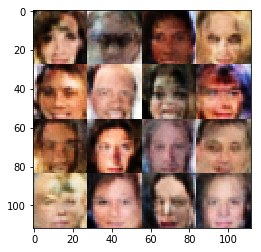

Epoch 1/1:   - Discriminator Loss: 1.2876:  - Generator Loss: 0.7503
Epoch 1/1:   - Discriminator Loss: 1.2981:  - Generator Loss: 0.6754
Epoch 1/1:   - Discriminator Loss: 1.3626:  - Generator Loss: 0.5380
Epoch 1/1:   - Discriminator Loss: 1.3936:  - Generator Loss: 0.6835
Epoch 1/1:   - Discriminator Loss: 1.2321:  - Generator Loss: 0.6598
Epoch 1/1:   - Discriminator Loss: 1.1949:  - Generator Loss: 0.8069
Epoch 1/1:   - Discriminator Loss: 1.2599:  - Generator Loss: 0.7695
Epoch 1/1:   - Discriminator Loss: 1.2744:  - Generator Loss: 0.7743
Epoch 1/1:   - Discriminator Loss: 1.2742:  - Generator Loss: 0.6318
Epoch 1/1:   - Discriminator Loss: 1.3375:  - Generator Loss: 0.6118


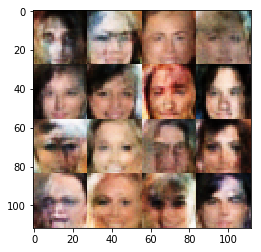

Epoch 1/1:   - Discriminator Loss: 1.2482:  - Generator Loss: 0.7141
Epoch 1/1:   - Discriminator Loss: 1.2615:  - Generator Loss: 0.6900
Epoch 1/1:   - Discriminator Loss: 1.1456:  - Generator Loss: 0.7047
Epoch 1/1:   - Discriminator Loss: 1.2093:  - Generator Loss: 0.8899
Epoch 1/1:   - Discriminator Loss: 1.3219:  - Generator Loss: 0.5710
Epoch 1/1:   - Discriminator Loss: 1.1750:  - Generator Loss: 0.7449
Epoch 1/1:   - Discriminator Loss: 1.3872:  - Generator Loss: 0.7205
Epoch 1/1:   - Discriminator Loss: 1.1241:  - Generator Loss: 0.7354
Epoch 1/1:   - Discriminator Loss: 1.3203:  - Generator Loss: 0.7222
Epoch 1/1:   - Discriminator Loss: 1.3536:  - Generator Loss: 0.6755


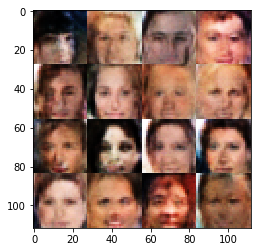

Epoch 1/1:   - Discriminator Loss: 1.1704:  - Generator Loss: 0.6931
Epoch 1/1:   - Discriminator Loss: 1.3164:  - Generator Loss: 0.7536
Epoch 1/1:   - Discriminator Loss: 1.2597:  - Generator Loss: 0.7381
Epoch 1/1:   - Discriminator Loss: 1.1496:  - Generator Loss: 0.7613
Epoch 1/1:   - Discriminator Loss: 1.2565:  - Generator Loss: 0.6885
Epoch 1/1:   - Discriminator Loss: 1.1892:  - Generator Loss: 0.8483
Epoch 1/1:   - Discriminator Loss: 1.3467:  - Generator Loss: 0.6937
Epoch 1/1:   - Discriminator Loss: 1.2892:  - Generator Loss: 0.7591
Epoch 1/1:   - Discriminator Loss: 1.3449:  - Generator Loss: 0.5737
Epoch 1/1:   - Discriminator Loss: 1.1671:  - Generator Loss: 0.8763


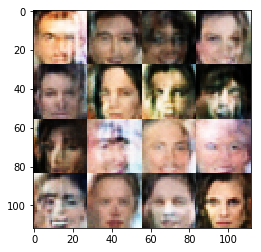

Epoch 1/1:   - Discriminator Loss: 0.9607:  - Generator Loss: 1.0188
Epoch 1/1:   - Discriminator Loss: 1.2006:  - Generator Loss: 0.7587
Epoch 1/1:   - Discriminator Loss: 1.2347:  - Generator Loss: 0.7003
Epoch 1/1:   - Discriminator Loss: 1.2681:  - Generator Loss: 0.6294
Epoch 1/1:   - Discriminator Loss: 1.4198:  - Generator Loss: 0.6384
Epoch 1/1:   - Discriminator Loss: 1.3827:  - Generator Loss: 0.6565
Epoch 1/1:   - Discriminator Loss: 1.2945:  - Generator Loss: 0.6779
Epoch 1/1:   - Discriminator Loss: 1.4639:  - Generator Loss: 0.6182
Epoch 1/1:   - Discriminator Loss: 1.2004:  - Generator Loss: 0.8273
Epoch 1/1:   - Discriminator Loss: 1.1725:  - Generator Loss: 0.7651


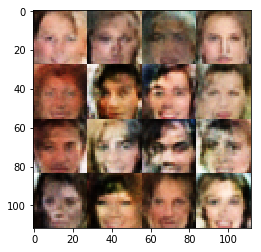

Epoch 1/1:   - Discriminator Loss: 1.1646:  - Generator Loss: 0.7082
Epoch 1/1:   - Discriminator Loss: 1.3247:  - Generator Loss: 0.6267
Epoch 1/1:   - Discriminator Loss: 1.3275:  - Generator Loss: 0.6782
Epoch 1/1:   - Discriminator Loss: 1.0738:  - Generator Loss: 0.9315
Epoch 1/1:   - Discriminator Loss: 1.3562:  - Generator Loss: 0.5826
Epoch 1/1:   - Discriminator Loss: 1.1368:  - Generator Loss: 0.7556
Epoch 1/1:   - Discriminator Loss: 1.2265:  - Generator Loss: 0.7624
Epoch 1/1:   - Discriminator Loss: 1.4067:  - Generator Loss: 0.6011
Epoch 1/1:   - Discriminator Loss: 1.2944:  - Generator Loss: 0.8393
Epoch 1/1:   - Discriminator Loss: 1.2247:  - Generator Loss: 0.7846


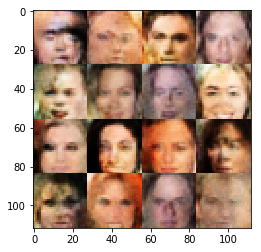

Epoch 1/1:   - Discriminator Loss: 1.0431:  - Generator Loss: 0.8953
Epoch 1/1:   - Discriminator Loss: 1.2918:  - Generator Loss: 0.6902
Epoch 1/1:   - Discriminator Loss: 1.1968:  - Generator Loss: 0.7499
DONE


In [ ]:
batch_size = 32
z_dim = 172
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.